
# **TDS Project1 September 2024**

Using the **GitHub API**, scrape all users in the city of **Chicago** with over **100** followers, and their repositories.

Create a **GitHub** repo with these files in the main branch:

users.csv. See below. Use the SAME values as in the API response. For booleans, use true and false and empty strings for null.
repositories.csv. See below. Use the SAME values as in the API response. For booleans, use true and false and empty strings for null.
README.md. See below.
Optional but recommended: your code and/or spreadsheet, in whichever language you analyzed the data in.
users.csv has following information about each user in Chicago with over 100 followers, with fields:

```
login: Their Github user ID
name: Their full name
company: The company they work at. Clean up company names. At least make sure:
They're trimmed of whitespace
Leading @ symbols are stripped
They are converted to UPPERCASE
location: The city they are in
email: Their email address
hireable: Whether they are open to being hired
bio: A short bio about them
public_repos: The number of public repositories they have
followers: The number of followers they have
following: The number of people they are following
created_at: When they joined Github`
```


repositories.csv has these users' public repositories. For each user in users.csv, fetch up to the 500 most recently pushed repositories, with fields:
```
login: The Github user ID (login) of the owner, which, BTW, is not directly in the API response.)
full_name: Full name of the repository
created_at: When the repository was created
stargazers_count: Number of stars the repository has
watchers_count: Number of watchers the repository has
language: The programming language the repository is written in
has_projects: Whether the repository has projects enabled
has_wiki: Whether the repository has a wiki
license_name: Name of the license the repository is under (This is under license.key)
```

# Scrape all users in the city of Chicago with over 100 followers, and their repositories.

In [ ]:
import requests
import csv
import os


# Step 1: Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')
userfile = '/content/drive/My Drive/TDS/users.csv'
repofile = '/content/drive/My Drive/TDS/repositories.csv'
# Step 2: GitHub API setup
os.environ['GITHUB_TOKEN'] = 'GIT HUB TOKEN'

# Access the token
GITHUB_TOKEN = os.getenv('GITHUB_TOKEN')
headers = {'Authorization': f'token {GITHUB_TOKEN}'}

# Step 3: Search users by location and minimum followers with pagination
def fetch_users_by_location(location, min_followers):
    users = []
    page = 1
    while True:

        url = f"https://api.github.com/search/users?q=location:{location}+followers:>{min_followers}&per_page=100&page={page}"

        #url = f"https://api.github.com/search/users?q=location:{location}+followers:{min_followers}&per_page=100&page={page}" # used for testing purposes
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            items = response.json()['items']
            users.extend(items)
            if len(items) < 100:  # If less than 100 items, we've reached the last page
                break
            page += 1  # Increment page to get more users
        else:
            print(f"Error fetching users: {response.status_code}")
            break
    return users

# Step 4:Retrieves detailed information for each user.
def fetch_user_details(username):
    url = f"https://api.github.com/users/{username}"
    response = requests.get(url, headers=headers)
    return response.json()

# Step 5: Fetch repositories for a user with pagination
def fetch_user_repos(username):
    repos = []
    page = 1
    while True:
        url = f"https://api.github.com/users/{username}/repos?per_page=100&page={page}"
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            user_repos = response.json()
            repos.extend(user_repos)
            if len(user_repos) < 100:  # If less than 100 repos, we've reached the last page
                break
            page += 1  # Increment page to get more repositories
        else:
            print(f"Error fetching repos for {username}: {response.status_code}")
            break
    return repos

# Step 6:Clean company name (strip @, uppercase, trim whitespace)
def clean_company(company_name):
    if company_name:
        company_name = company_name.strip().lstrip('@').upper()
    return company_name

# Step 7: Writes user data to users.csv.
def save_users_to_csv(users):
    with open(userfile, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['login', 'name', 'company', 'location', 'email', 'hireable', 'bio', 'public_repos', 'followers', 'following', 'created_at']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for user in users:
            writer.writerow(user)


# Step 8: Writes repository data to repositories.csv.
def save_repos_to_csv(repos):
    with open(repofile, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['login', 'full_name', 'created_at', 'stargazers_count', 'watchers_count', 'language', 'has_projects', 'has_wiki', 'license_name']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for repo in repos:
            writer.writerow(repo)

# Prompt for location and minimum followers
location = input("Enter the location (e.g., chicago): ").strip().lower()
min_followers = int(input("Enter the cutof number of over followers (e.g., 100): "))

# Step 9:  Main process
if __name__ == "__main__":

    users = []
    repos = []

    # Fetch users by location and minimum followers
    user_items = fetch_users_by_location(location, min_followers)

    for user_item in user_items:
        username = user_item['login']
        user_details = fetch_user_details(username)

        # Prepare user data for users.csv
        user = {
            'login': user_details['login'],
            'name': user_details.get('name', ''),
            'company': clean_company(user_details.get('company', '')),
            'location': user_details.get('location', ''),
            'email': user_details.get('email', ''),
            #'hireable': str(user_details.get('hireable', False)).lower(),
            'hireable': str(user_details.get('hireable') or False).lower(),
            'bio': user_details.get('bio', ''),
            'public_repos': user_details.get('public_repos', 0),
            'followers': user_details.get('followers', 0),
            'following': user_details.get('following', 0),
            'created_at': user_details.get('created_at', '')
        }
        users.append(user)

        # Fetch repositories and prepare data for repositories.csv
        user_repos = fetch_user_repos(username)
        for repo in user_repos[:500]:
            repository = {
                'login': user_details['login'],
                'full_name': repo['full_name'],
                'created_at': repo['created_at'],
                'stargazers_count': repo['stargazers_count'],
                'watchers_count': repo['watchers_count'],
                'language': repo['language'],
                'has_projects': str(repo.get('has_projects', False)).lower(),
                'has_wiki': str(repo.get('has_wiki', False)).lower(),
                'license_name': repo['license']['name'] if repo['license'] else ''
            }
            repos.append(repository)

  # Step 10: Save data to CSV files
    save_users_to_csv(users)
    save_repos_to_csv(repos)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter the location (e.g., chicago): Chicago
Enter the cutof number of over followers (e.g., 100): 100


# Setting up file path for processing data

In [ ]:
import os
from google.colab import drive
# Check if Google Drive is already mounted
if not os.path.ismount('/content/drive'):
    # This will prompt you to authorize access
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")

# Step 2: Read the CSV file using pandas
import pandas as pd
print('# repos')
# Specify the path to your CSV file
file_pathr = '/content/drive/My Drive/TDS/repositories.csv'

# Read the CSV file into a DataFrame
repositories_df = pd.read_csv(file_pathr)

# Step 3: Convert DataFrame to a list of dictionaries
repositories = repositories_df.to_dict(orient='records')

# Optional: Display the first few entries to confirm it worked
print(repositories[:5])  # Print the first 5 repositories

print('# Susers')
# Specify the path to your CSV file
file_pathu = '/content/drive/My Drive/TDS/users.csv'

# Read the CSV file into a DataFrame
users_df = pd.read_csv(file_pathu)

# Step 3: Convert DataFrame to a list of dictionaries
users = users_df.to_dict(orient='records')

# Optional: Display the first few entries to confirm it worked
print(users[:5])  # Print the first 5 repositories


Mounted at /content/drive
# repos
[{'login': 'cassidoo', 'full_name': 'cassidoo/accordion', 'created_at': '2020-01-23T13:19:32Z', 'stargazers_count': 17, 'watchers_count': 17, 'language': 'JavaScript', 'has_projects': True, 'has_wiki': True, 'license_name': nan}, {'login': 'cassidoo', 'full_name': 'cassidoo/agagd', 'created_at': '2023-11-20T05:21:51Z', 'stargazers_count': 1, 'watchers_count': 1, 'language': nan, 'has_projects': True, 'has_wiki': False, 'license_name': 'MIT License'}, {'login': 'cassidoo', 'full_name': 'cassidoo/ama', 'created_at': '2020-06-09T02:22:18Z', 'stargazers_count': 62, 'watchers_count': 62, 'language': nan, 'has_projects': False, 'has_wiki': False, 'license_name': nan}, {'login': 'cassidoo', 'full_name': 'cassidoo/ASL2048', 'created_at': '2014-03-20T14:29:23Z', 'stargazers_count': 0, 'watchers_count': 0, 'language': 'CSS', 'has_projects': True, 'has_wiki': True, 'license_name': 'MIT License'}, {'login': 'cassidoo', 'full_name': 'cassidoo/astro', 'created_at': 

#Q1: Who are the top 5 users in Chicago with the highest number of followers? List their login in order, comma-separated.

In [ ]:
# Function to find top 5 users in Chicago by followers
def top_5_users_by_followers(users):
    # Sort users by number of followers in descending order
    top_users = sorted(users, key=lambda x: x['followers'], reverse=True)

    # Get the logins of the top 5 users
    top_5_logins = [user['login'] for user in top_users[:5]]

    # Join the logins as a comma-separated string
    return ','.join(top_5_logins)

# Assuming the 'users' list is already populated
top_5_logins = top_5_users_by_followers(users)

# Print the top 5 logins
print("Top 5 users in Chicago by followers:", top_5_logins)

Top 5 users in Chicago by followers: cassidoo,felangel,dabeaz,sstephenson,mattgodbolt


#Q2. Who are the 5 earliest registered GitHub users in Chicago? List their login in ascending order of created_at, comma-separated.

In [ ]:
# Function to find the 5 earliest registered users in Chicago
def earliest_5_users_by_registration(users):
    # Sort users by created_at date in ascending order
    earliest_users = sorted(users, key=lambda x: x['created_at'])

    # Get the logins of the earliest 5 users
    earliest_5_logins = [user['login'] for user in earliest_users[:5]]

    # Join the logins as a comma-separated string
    return ','.join(earliest_5_logins)

# Assuming the 'users' list is already populated
earliest_5_logins = earliest_5_users_by_registration(users)

# Print the earliest 5 logins
print("Earliest 5 users in Chicago by registration date:", earliest_5_logins)

Earliest 5 users in Chicago by registration date: ELLIOTTCABLE,trevorturk,lukehoersten,djspiewak,shanesveller


#Q3. What are the 3 most popular license among these users? Ignore missing licenses. List the license_name in order, comma-separated.

In [ ]:
from collections import Counter
def top_3_licenses(repositories):
    license_counter = Counter()

    # Count licenses from the repositories
    for repo in repositories:
        license_name = repo['license_name']
        if isinstance(license_name, str) and license_name:  # Check if it's a valid string
            license_counter[license_name] += 1

    # Find the top 3 licenses by count
    top_licenses = license_counter.most_common(3)

    # Extract just the license names from the top licenses
    top_3_licenses = [license[0] for license in top_licenses]

    # Join the top 3 licenses as a comma-separated string
    return ','.join(top_3_licenses)

# Assuming the 'repositories' list is already populated
top_3_licenses = top_3_licenses(repositories)

# Print the top 3 licenses
print(f"The top 3 licenses are: {top_3_licenses}")


The top 3 licenses are: MIT License,Other,Apache License 2.0


In [ ]:
import csv
from collections import Counter

# Define the list to store license names
licenses = []

# Read the CSV file with UTF-8 encoding
with open(file_pathr, 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        # Check if the license_name field is present and not empty
        license_name = row.get('license_name', '').strip()
        if license_name:
            licenses.append(license_name)

# Count the occurrence of each license
license_counts = Counter(licenses)

# Get the 3 most common licenses
top_3_licenses = [license for license, count in license_counts.most_common(3)]

# Print the result as a comma-separated list
print(','.join(top_3_licenses))


MIT License,Other,Apache License 2.0


#Q4. Which company do the majority of these developers work at?

In [ ]:
from collections import Counter

def most_common_company(users):
    # Extract non-empty company names, ensuring they are properly cleaned (trimmed and uppercase)
    companies = [
        user['company'].strip().upper()
        for user in users
        if isinstance(user['company'], str) and user['company'].strip()
    ]

    # Count the occurrences of each company
    company_counter = Counter(companies)

    # Find the most common company
    if company_counter:  # Ensure there is at least one company counted
        most_common_company = company_counter.most_common(1)[0]
        return most_common_company[0]  # Return just the company name
    else:
        return None  # Handle the case with no companies

# Assuming the 'users' list is already populated
most_common_company = most_common_company(users)

# Print the company with the majority of developers
if most_common_company:
    print(f"The company with the majority of developers is: {most_common_company}")
else:
    print("No companies found.")


The company with the majority of developers is: UNIVERSITY OF CHICAGO


#Q5. Which programming language is most popular among these users?

In [ ]:
from collections import Counter

def most_popular_language(repositories):
    # Extract non-empty programming languages, ignoring spaces
    languages = [
        repo['language'].strip()  # Strip whitespace from the language
        for repo in repositories
        if 'language' in repo and isinstance(repo['language'], str) and repo['language'].strip()  # Only include valid languages
    ]

    # Count occurrences of each language
    language_counter = Counter(languages)

    # Find the most common language
    if language_counter:  # Ensure there is at least one language counted
        most_common_language = language_counter.most_common(1)[0]
        return most_common_language[0]  # Return just the language name
    else:
        return None  # Handle the case with no languages

# Assuming the 'repositories' list is already populated with user languages
most_popular_language = most_popular_language(repositories)

# Print the most popular programming language
if most_popular_language:
    print(f"The most popular programming language is: {most_popular_language}")
else:
    print("No programming languages found.")


The most popular programming language is: JavaScript


#Q6: Which programming language is the second most popular among users who joined after 2020?

In [ ]:
import csv
from collections import Counter
from datetime import datetime

# Define the list to store programming languages
languages = []

# Read the CSV file with UTF-8 encoding
with open(file_pathr, 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)

    # Iterate through the rows in the CSV
    for row in reader:
        # Parse the created_at field
        created_at = row.get('created_at', '').strip()

        # Convert the date string to a datetime object
        if created_at:
            user_join_date = datetime.strptime(created_at, "%Y-%m-%dT%H:%M:%SZ")

            # Check if the user joined after 2020
            if user_join_date.year > 2020:
                # Get the language field and clean it up
                language = row.get('language', '').strip()
                if language:
                    languages.append(language)

# Count the occurrence of each language
language_counts = Counter(languages)

# Find the two most common languages
most_common_languages = language_counts.most_common(2)

# Print the second most common language
if len(most_common_languages) >= 2:
    print(most_common_languages[1][0])  # Second most common language
else:
    print("Not enough language data found.")

JavaScript


#Q7: Which language has the highest average number of stars per repository?

In [ ]:
from collections import defaultdict

# Function to find the language with the highest average number of stars per repository
def language_with_highest_avg_stars(repositories):
    # Dictionary to accumulate total stars and repository counts per language
    language_stats = defaultdict(lambda: {'stars': 0, 'repo_count': 0})

    # Accumulate stars and repository count for each language
    for repo in repositories:
        if repo['language']:  # Ignore repositories without a language
            language_stats[repo['language']]['stars'] += repo['stargazers_count']
            language_stats[repo['language']]['repo_count'] += 1

    # Calculate average stars for each language
    avg_stars_per_language = {lang: stats['stars'] / stats['repo_count'] for lang, stats in language_stats.items() if stats['repo_count'] > 0}

    # Find the language with the highest average stars
    language_with_highest_avg = max(avg_stars_per_language, key=avg_stars_per_language.get)

    return language_with_highest_avg, avg_stars_per_language[language_with_highest_avg]

# Assuming the 'repositories' list is already populated
language, avg_stars = language_with_highest_avg_stars(repositories)

# Print the result
print(f"Programming language with the highest average stars per repository: {language} with {avg_stars:.2f} stars on average.")

Programming language with the highest average stars per repository: Vim Script with 647.36 stars on average.


# Q8:Let's define leader_strength as followers / (1 + following). Who are the top 5 in terms of leader_strength? List their login in order, comma-separated.

In [ ]:
# Function to calculate leader_strength and find top 5 users
def top_5_by_leader_strength(users):
    # Calculate leader_strength for each user and add it to the user dictionary
    for user in users:
        user['leader_strength'] = user['followers'] / (1 + user['following'])

    # Sort users by leader_strength in descending order
    top_users = sorted(users, key=lambda x: x['leader_strength'], reverse=True)

    # Get the logins of the top 5 users
    top_5_logins = [user['login'] for user in top_users[:5]]

    # Join the logins as a comma-separated string
    return ','.join(top_5_logins)

# Assuming the 'users' list is already populated
top_5_leader_strength_logins = top_5_by_leader_strength(users)

# Print the top 5 logins based on leader_strength
print("Top 5 users by leader_strength:", top_5_leader_strength_logins)


Top 5 users by leader_strength: dabeaz,sstephenson,khan4019,adashofdata,djspiewak


#Q9. What is the correlation between the number of followers and the number of public repositories among users in Chicago?

In [ ]:
from scipy.stats import pearsonr

# Function to calculate the correlation between followers and public repositories
def calculate_correlation(users):
    # Extract the number of followers and public repositories for each user
    followers = [user['followers'] for user in users]
    public_repos = [user['public_repos'] for user in users]

    # Calculate the Pearson correlation coefficient
    correlation, _ = pearsonr(followers, public_repos)

    return correlation

# Assuming the 'users' list is already populated
correlation = calculate_correlation(users)

# Print the correlation result
print(f"Correlation between number of followers and number of public repositories: {correlation:.3f}")


Correlation between number of followers and number of public repositories: 0.082


#Q10. Does creating more repos help users get more followers? Using regression, estimate how many additional followers a user gets per additional public repository.
Regression slope of followers on repos (to 3 decimal places, e.g. 0.123 or -0.123


In [ ]:
import numpy as np
import statsmodels.api as sm

# Function to perform linear regression and get the slope
def estimate_additional_followers(users):
    # Extract the number of followers and public repositories
    followers = np.array([user['followers'] for user in users])
    public_repos = np.array([user['public_repos'] for user in users])

    # Add a constant to the independent variable (public_repos) for the intercept
    X = sm.add_constant(public_repos)

    # Fit the regression model
    model = sm.OLS(followers, X).fit()

    # Get the slope (coefficient for public_repos)
    slope = model.params[1]  # params[0] is the intercept, params[1] is the slope for public_repos

    return round(slope, 3)

# Assuming the 'users' list is already populated
additional_followers_per_repo = estimate_additional_followers(users)

# Print the estimated slope
print(f"Estimated additional followers per additional public repository: {additional_followers_per_repo}")


Estimated additional followers per additional public repository: 0.676


#Q11. Do people typically enable projects and wikis together? What is the correlation between a repo having projects enabled and having wiki enabled?
Correlation between projects and wiki enabled (to 3 decimal places, e.g. 0.123 or -0.123)


In [ ]:
import pandas as pd

# Load the repositories.csv file
repositories_df = pd.read_csv(file_pathr)  # Make sure to update the path

# Convert 'TRUE'/'FALSE' strings to boolean
repositories_df['has_projects'] = repositories_df['has_projects'].apply(lambda x: 1 if str(x).upper() == 'TRUE' else 0)
repositories_df['has_wiki'] = repositories_df['has_wiki'].apply(lambda x: 1 if str(x).upper() == 'TRUE' else 0)

# Now calculate the correlation between has_projects and has_wiki
correlation = repositories_df['has_projects'].corr(repositories_df['has_wiki'])

# Print the result rounded to 3 decimal places
print(f"Correlation between projects and wiki enabled: {correlation:.3f}")


Correlation between projects and wiki enabled: 0.289


In [ ]:
from scipy.stats import pearsonr

# Function to calculate the correlation between having projects and having wikis enabled
def calculate_projects_wiki_correlation(repositories):
    # Extract has_projects and has_wiki as binary values
    has_projects = [1 if repo['has_projects'] else 0 for repo in repositories]
    has_wiki = [1 if repo['has_wiki'] else 0 for repo in repositories]

    # Calculate the Pearson correlation coefficient
    correlation, _ = pearsonr(has_projects, has_wiki)

    return round(correlation, 3)

# Assuming the 'repositories' list is already populated
correlation_projects_wiki = calculate_projects_wiki_correlation(repositories)

# Print the correlation result
print(f"Correlation between having projects and having wikis enabled: {correlation_projects_wiki:.3f}")


Correlation between having projects and having wikis enabled: 0.289


#Q12. Do hireable users follow more people than those who are not hireable?
Average of following per user for hireable=true minus the average following for the rest (to 3 decimal places, e.g. 12.345 or -12.345)


In [ ]:
import pandas as pd

# Read CSV file
df = pd.read_csv(file_pathu)

# Calculate average following for hireable users
hireable_avg = df[df['hireable'] == True]['following'].mean()

# Calculate average following for non-hireable users
non_hireable_avg = df[df['hireable'] == False]['following'].mean()

# Calculate and print the difference (hireable - non_hireable) to 3 decimal places
difference = hireable_avg - non_hireable_avg
print(f"{difference:.3f}")

106.026


In [ ]:
import pandas as pd

def analyze_following_difference(users_csv_path=file_pathu):
    # Read the data
    df = pd.read_csv(users_csv_path)

    # Calculate average following for hireable users
    hireable_following = df[df['hireable'] == True]['following'].mean()

    # Calculate average following for non-hireable users
    non_hireable_following = df[df['hireable'] != True]['following'].mean()

    # Calculate the difference rounded to 3 decimal places
    difference = round(hireable_following - non_hireable_following, 3)

    # Print debug information
    print(f"Number of hireable users: {len(df[df['hireable'] == True])}")
    print(f"Number of non-hireable users: {len(df[df['hireable'] != True])}")
    print(f"Average following for hireable users: {hireable_following:.3f}")
    print(f"Average following for non-hireable users: {non_hireable_following:.3f}")

    return difference

# Calculate the difference
result = analyze_following_difference()
print(f"\nDifference in average following: {result:.3f}")


Number of hireable users: 93
Number of non-hireable users: 282
Average following for hireable users: 209.075
Average following for non-hireable users: 103.050

Difference in average following: 106.026


#Q13. Some developers write long bios. Does that help them get more followers? What's the correlation of the length of their bio (in Unicode characters) with followers? (Ignore people without bios)
Regression slope of followers on bio word count (to 3 decimal places, e.g. 12.345 or -12.345


In [ ]:
import pandas as pd
from scipy.stats import linregress

# Load CSV data from the URL
url = "https://raw.githubusercontent.com/joy-pro26/Test1/refs/heads/main/users.csv"
users = pd.read_csv(url)

# Filter users who have bios
bios = users[users['bio'].notna()]

# Calculate bio word count and prepare data for linear regression
bios['bio_word_count'] = bios['bio'].apply(lambda x: len(str(x).split()))
x = bios['bio_word_count']  # Bio word count
y = bios['followers']       # Followers

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Display the slope to 3 decimal places
print(f"The regression slope of followers on bio word count is approximately {slope:.3f}.")


The regression slope of followers on bio word count is approximately 2.813.


<ipython-input-1-4898f4a1eafc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bios['bio_word_count'] = bios['bio'].apply(lambda x: len(str(x).split()))


In [ ]:
import pandas as pd

# Load CSV data from the URL
url = "https://raw.githubusercontent.com/joy-pro26/Test1/refs/heads/main/users.csv"
users = pd.read_csv(url)

# Filter users who have bios
bios = users[users['bio'].notna()]

# Calculate bio word count and followers as numeric lists
bios['bio_word_count'] = bios['bio'].apply(lambda x: len(str(x).split()))
x = bios['bio_word_count'].tolist()  # Bio word count
y = bios['followers'].tolist()       # Followers

# Calculate sums and means needed for regression slope calculation
n = len(x)
sum_x = sum(x)
sum_y = sum(y)
sum_xy = sum([xi * yi for xi, yi in zip(x, y)])
sum_x2 = sum([xi**2 for xi in x])

# Calculate the slope (m)
slope = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x**2)

# Display the slope to 3 decimal places
print(f"The regression slope of followers on bio word count is approximately {slope:.3f}.")


The regression slope of followers on bio word count is approximately 2.813.


<ipython-input-2-8737b8ce893b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bios['bio_word_count'] = bios['bio'].apply(lambda x: len(str(x).split()))


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import re

# Load data from CSV
#url = "https://raw.githubusercontent.com/joy-pro26/Test1/refs/heads/main/users.csv"
df = pd.read_csv(file_pathu)

# Filter out entries without a bio
df = df.dropna(subset=['bio'])

# Calculate word count for each bio (counting sequences of non-whitespace)
df['bio_word_count'] = df['bio'].apply(lambda x: len(re.findall(r'\s+', str(x))))

# Perform linear regression on followers vs bio word count
slope, intercept, r_value, p_value, std_err = linregress(df['bio_word_count'], df['followers'])

# Output the slope to 3 decimal places
print(f"Regression slope of followers on bio word count: {slope:.3f}")

Regression slope of followers on bio word count: 2.760


#Q14. Who created the most repositories on weekends (UTC)? List the top 5 users' login in order, comma-separated

In [ ]:
from collections import Counter
from datetime import datetime

def get_top_5_weekend_repo_creators(repositories):
    weekend_repo_counts = Counter()

    # Loop through each repository to count weekend creations
    for repo in repositories:
        # Parse the creation date
        created_at = datetime.strptime(repo['created_at'], '%Y-%m-%dT%H:%M:%SZ')

        # Check if the created_at day is Saturday (5) or Sunday (6)
        if created_at.weekday() in [5, 6]:  # 5 = Saturday, 6 = Sunday
            weekend_repo_counts[repo['login']] += 1  # Count the repositories for the user

    # Get the top 5 users based on the count
    top_users = weekend_repo_counts.most_common(5)

    # Extract logins in order
    top_5_logins = [user[0] for user in top_users]

    # Return as a comma-separated string
    return ','.join(top_5_logins)

# Assuming the 'repositories' list is already populated
top_5_weekend_creators = get_top_5_weekend_repo_creators(repositories)

# Print the top 5 logins who created the most repositories on weekends
print(f"Top 5 users who created the most repositories on weekends: {top_5_weekend_creators}")


Top 5 users who created the most repositories on weekends: marwahaha,eddelbuettel,sabre1041,yyolk,austinsonger


#Q15. Do people who are hireable share their email addresses more often?
[fraction of users with email when hireable=true] minus [fraction of users with email for the rest] (to 3 decimal places, e.g. 0.123 or -0.123)


In [ ]:
import pandas as pd

def analyze_email_sharing(users_csv_path=file_pathu):
    # Read the complete CSV file
    df = pd.read_csv(users_csv_path)

    # Convert email column to boolean (True if email exists, False if NaN or empty)
    df['has_email'] = df['email'].notna() & (df['email'] != '')

    # Calculate for hireable users
    hireable_mask = df['hireable'] == True
    if hireable_mask.any():
        hireable_email_fraction = df[hireable_mask]['has_email'].mean()
    else:
        hireable_email_fraction = 0

    # Calculate for non-hireable users
    non_hireable_mask = df['hireable'] != True
    if non_hireable_mask.any():
        non_hireable_email_fraction = df[non_hireable_mask]['has_email'].mean()
    else:
        non_hireable_email_fraction = 0

    # Calculate difference and round to 3 decimal places
    difference = round(hireable_email_fraction - non_hireable_email_fraction, 3)

    # Print debug information
    print(f"Total users: {len(df)}")
    print(f"Hireable users with email: {df[hireable_mask]['has_email'].sum()}/{hireable_mask.sum()}")
    print(f"Non-hireable users with email: {df[non_hireable_mask]['has_email'].sum()}/{non_hireable_mask.sum()}")
    print(f"Hireable fraction: {hireable_email_fraction:.3f}")
    print(f"Non-hireable fraction: {non_hireable_email_fraction:.3f}")

    return difference

# Read and analyze the complete dataset
result = analyze_email_sharing()
print(f"\nFinal result: {result:.3f}")

Total users: 375
Hireable users with email: 49/93
Non-hireable users with email: 134/282
Hireable fraction: 0.527
Non-hireable fraction: 0.475

Final result: 0.052


#Q16. Let's assume that the last word in a user's name is their surname (ignore missing names, trim and split by whitespace.) What's the most common surname? (If there's a tie, list them all, comma-separated, alphabetically)

In [ ]:
import csv
from collections import Counter

# Counter to store surname frequencies
surname_counter = Counter()

# Open the users.csv file and read data
with open(file_pathu, 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)

    for row in reader:
        name = row.get('name', '').strip()
        if name:  # Ignore missing names
            # Split the name by whitespace
            name_parts = name.split()
            if len(name_parts) > 1:  # Only consider names with more than one word
                surname = name_parts[-1]  # Get the last word as the surname
                surname_counter[surname] += 1

# Find the maximum frequency of surnames
if surname_counter:
    max_count = max(surname_counter.values())
    # Get all surnames with the maximum frequency
    most_common_surnames = [surname for surname, count in surname_counter.items() if count == max_count]
    # Sort surnames alphabetically
    most_common_surnames.sort()
    # Output the result
    print(f"{','.join(most_common_surnames)}: {max_count}")
else:
    print("No valid surnames found.")


Baker,Chen,Chu,Fuller,Jones,King,LLC,Miller,Olsen,Sadykov,Smith,Turk,Zhang: 2


#GitHub Users Analysis

<ipython-input-8-1d834f87beed>:37: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
<ipython-input-8-1d834f87beed>:66: UserWarning: Glyph 23453 (\N{CJK UNIFIED IDEOGRAPH-5B9D}) missing from current font.
  plt.tight_layout()
<ipython-input-8-1d834f87beed>:66: UserWarning: Glyph 29577 (\N{CJK UNIFIED IDEOGRAPH-7389}) missing from current font.
  plt.tight_layout()
<ipython-input-8-1d834f87beed>:66: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  plt.tight_layout()


Key Insights:

1. Top Developers by Followers:
                name  followers                     company
0   Cassidy Williams      13367                      GITHUB
1      Felix Angelov       8669               SHOREBIRDTECH
2      David Beazley       5175                 DABEAZ, LLC
3     Sam Stephenson       3762                         NaN
4       Matt Godbolt       3396  AQUATIC CAPITAL MANAGEMENT
5  Logan Kilpatrick        2729                      GOOGLE
6       That JS Dude       2663                     NIELSEN
7         Alice Zhao       2451                         NaN
8     Daniel Spiewak       2303                      NVIDIA
9  Dirk Eddelbuettel       1849                         NaN

2. Most Efficient Growth (Followers/Year):
                 name  followers_per_year                     company
0    Cassidy Williams         1054.070575                      GITHUB
84       Joseph Mitch         1008.424736          KEY2MOON SOLUTIONS
1       Felix Angelov          858.6872

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 23453 (\N{CJK UNIFIED IDEOGRAPH-5B9D}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 29577 (\N{CJK UNIFIED IDEOGRAPH-7389}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23453 (\N{CJK UNIFIED IDEOGRAPH-5B9D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29577 (\N{CJK UNIFIED IDEOGRAPH-7389}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1

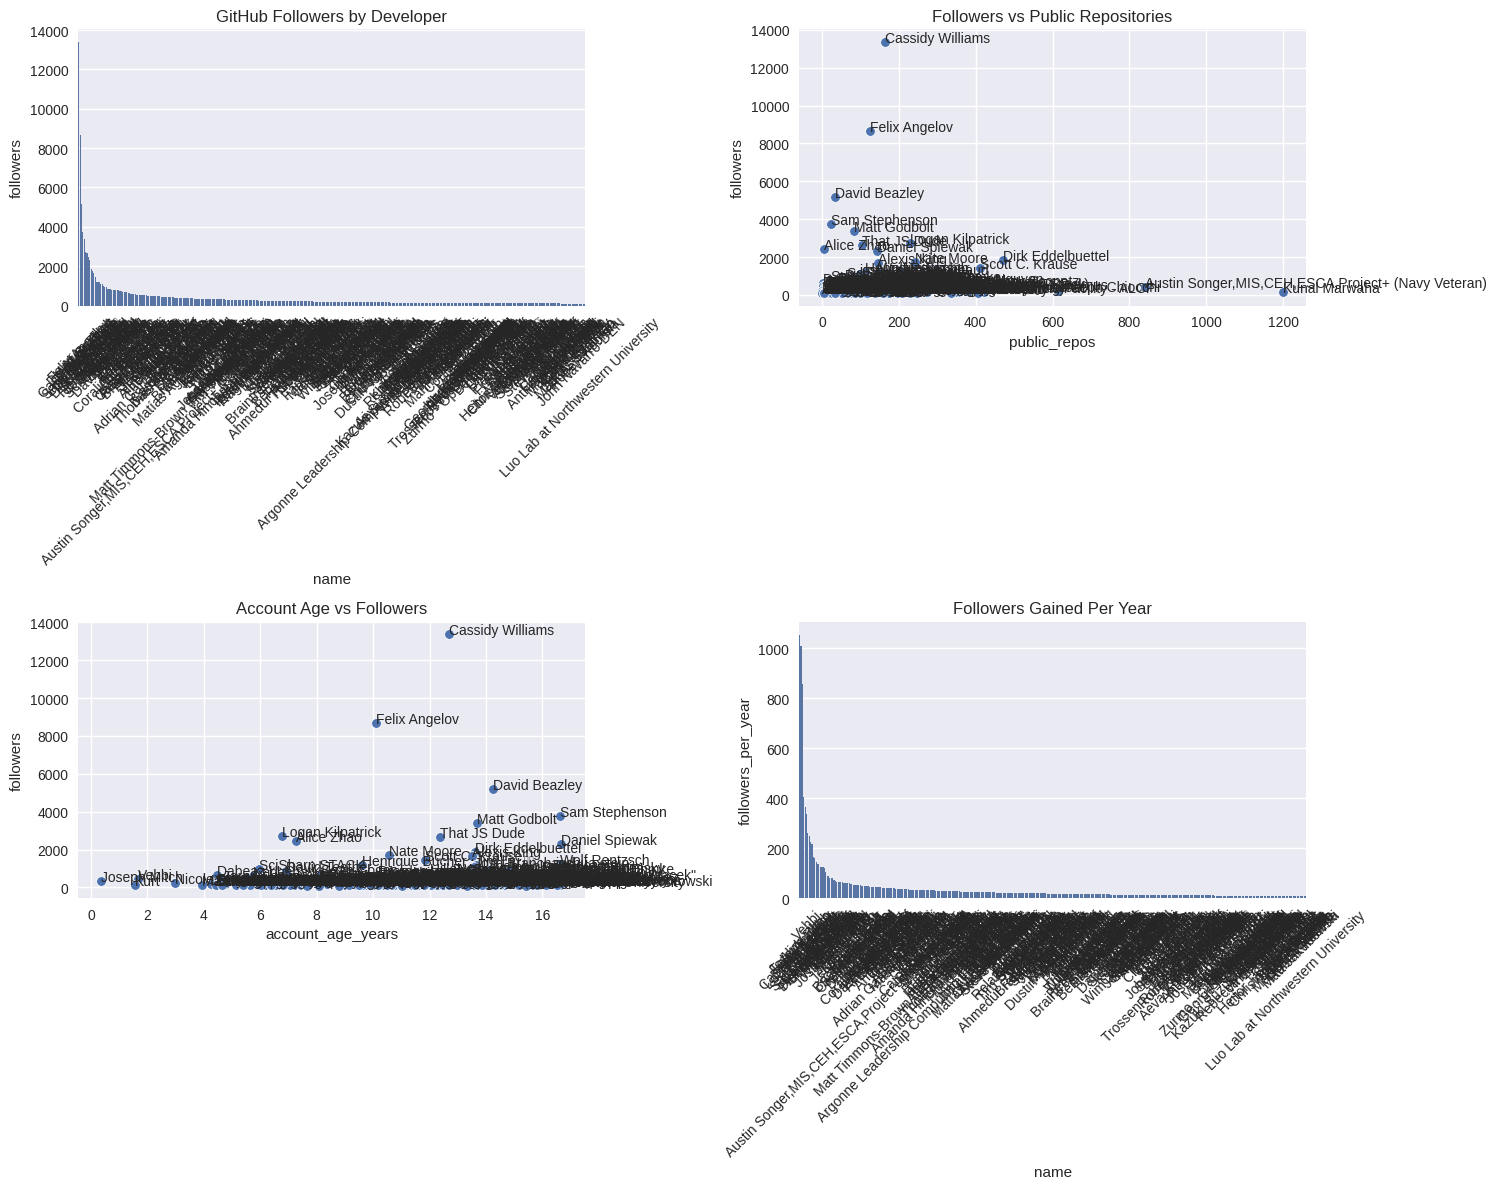

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np


# Convert string to DataFrame
df = pd.read_csv(file_pathu)

# Convert created_at to datetime
# Convert 'created_at' to datetime and make it timezone-naive
df['created_at'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)

# Calculate account age in years with a timezone-naive datetime
df['account_age_years'] = (datetime.now() - df['created_at']).dt.total_seconds() / (365.25 * 24 * 60 * 60)

# Calculate followers per year
df['followers_per_year'] = df['followers'] / df['account_age_years']

# Analysis functions
def analyze_top_companies(df):
    """Analyze company distribution"""
    company_counts = df['company'].value_counts()
    return company_counts

def analyze_account_growth(df):
    """Analyze follower growth rates"""
    growth_metrics = df.sort_values('followers_per_year', ascending=False)[
        ['name', 'followers', 'account_age_years', 'followers_per_year']
    ]
    return growth_metrics

def create_visualizations(df):
    """Create various visualizations"""
    # Set up the plotting style
    plt.style.use('seaborn')

    # Create a figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Followers Distribution
    sns.barplot(data=df.sort_values('followers', ascending=False),
                x='name', y='followers', ax=ax1)
    ax1.set_title('GitHub Followers by Developer')
    ax1.tick_params(axis='x', rotation=45)

    # 2. Followers vs Public Repos
    sns.scatterplot(data=df, x='public_repos', y='followers', ax=ax2)
    ax2.set_title('Followers vs Public Repositories')
    for i, row in df.iterrows():
        ax2.annotate(row['name'], (row['public_repos'], row['followers']))

    # 3. Account Age vs Followers
    sns.scatterplot(data=df, x='account_age_years', y='followers', ax=ax3)
    ax3.set_title('Account Age vs Followers')
    for i, row in df.iterrows():
        ax3.annotate(row['name'], (row['account_age_years'], row['followers']))

    # 4. Followers Per Year
    sns.barplot(data=df.sort_values('followers_per_year', ascending=False),
                x='name', y='followers_per_year', ax=ax4)
    ax4.set_title('Followers Gained Per Year')
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig

# Perform analysis
company_analysis = analyze_top_companies(df)
growth_analysis = analyze_account_growth(df)
fig = create_visualizations(df)

# Print insights
print("Key Insights:\n")
print("1. Top Developers by Followers:")
print(df.nlargest(10, 'followers')[['name', 'followers', 'company']])
print("\n2. Most Efficient Growth (Followers/Year):")
print(df.nlargest(10, 'followers_per_year')[['name', 'followers_per_year', 'company']])
print("\n3. Companies Represented:")
print(company_analysis)
print("\n4. Repository Activity:")
print(df.nlargest(10, 'public_repos')[['name', 'public_repos', 'followers']])

#GitHub Repositories Analysis

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Detailed Statistics:
Total repositories analyzed: 34354
Repositories with projects enabled: 97.9%
Repositories with wikis enabled: 84.8%
Repositories with both enabled: 84.5%


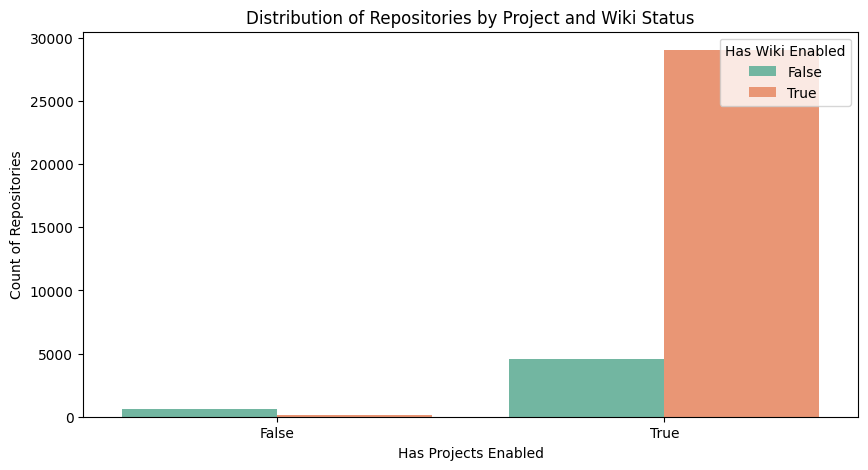

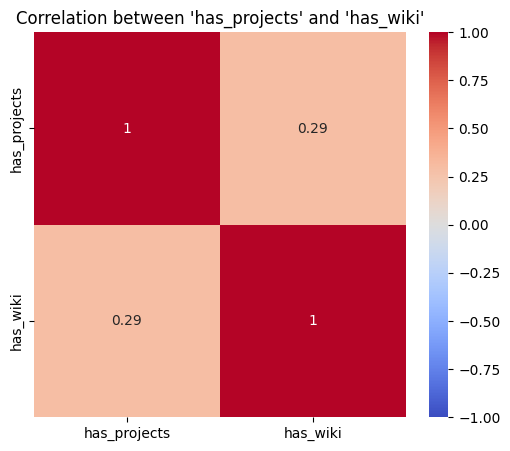

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

def load_and_analyze_repos(file_pathre):
    # Read CSV file
    df = pd.read_csv(file_pathre)

    # Check for the presence of columns
    if 'has_projects' not in df.columns or 'has_wiki' not in df.columns:
        print("Required columns 'has_projects' or 'has_wiki' are missing.")
        return None

    # Convert to boolean
    def convert_to_bool(x):
        if isinstance(x, bool):
            return x
        if isinstance(x, str):
            return x.lower() in ['true', 't', 'yes', 'y', '1']
        if isinstance(x, (int, float)):
            return bool(x)
        return False

    # Convert columns to boolean
    df['has_projects'] = df['has_projects'].apply(convert_to_bool)
    df['has_wiki'] = df['has_wiki'].apply(convert_to_bool)

    # Insights
    total_repos = len(df)
    projects_enabled = df['has_projects'].sum()
    wikis_enabled = df['has_wiki'].sum()
    both_enabled = df[df['has_projects'] & df['has_wiki']].shape[0]

    # Calculate statistics
    stats = {
        'total_repos': total_repos,
        'projects_enabled_percent': round(projects_enabled / total_repos * 100, 1),
        'wikis_enabled_percent': round(wikis_enabled / total_repos * 100, 1),
        'both_enabled_percent': round(both_enabled / total_repos * 100, 1)
    }

    print("\nDetailed Statistics:")
    print(f"Total repositories analyzed: {stats['total_repos']}")
    print(f"Repositories with projects enabled: {stats['projects_enabled_percent']}%")
    print(f"Repositories with wikis enabled: {stats['wikis_enabled_percent']}%")
    print(f"Repositories with both enabled: {stats['both_enabled_percent']}%")

    # Graph 1: Distribution of Repositories with Projects and Wikis Enabled
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x="has_projects", hue="has_wiki", palette="Set2")
    plt.title("Distribution of Repositories by Project and Wiki Status")
    plt.xlabel("Has Projects Enabled")
    plt.ylabel("Count of Repositories")
    plt.legend(title="Has Wiki Enabled", loc="upper right")
    plt.show()

    # Graph 2: Heatmap of Correlation Between Features
    plt.figure(figsize=(6, 5))
    sns.heatmap(df[['has_projects', 'has_wiki']].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation between 'has_projects' and 'has_wiki'")
    plt.show()

    return stats

# Usage example:
file_pathre = '/content/drive/My Drive/TDS/repositories.csv'
stats = load_and_analyze_repos(file_pathre)



# Bio Word counts vs  Followers  Analysis

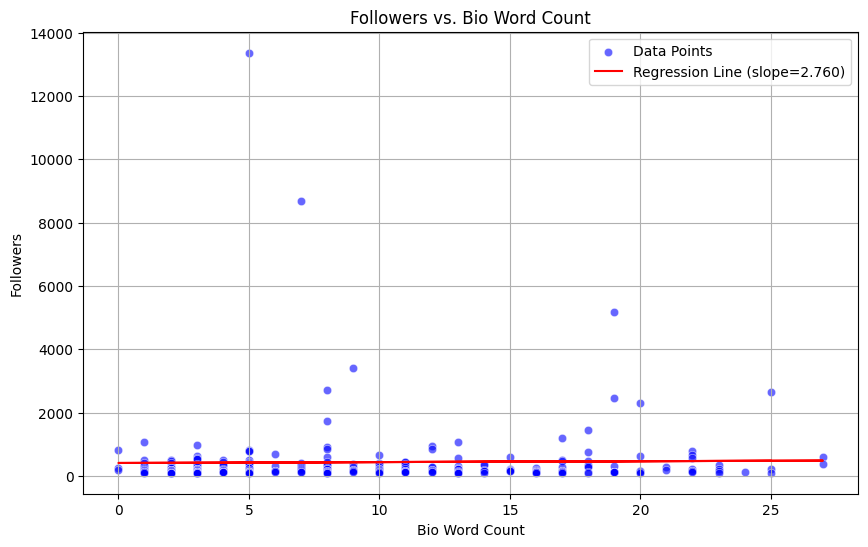

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import re

# Load data from CSV
url = "https://raw.githubusercontent.com/joy-pro26/Test1/refs/heads/main/users.csv"  # Replace with actual path or URL
df = pd.read_csv(url)

# Filter out entries without a bio
df = df.dropna(subset=['bio'])

# Calculate word count for each bio (counting words separated by whitespace)
df['bio_word_count'] = df['bio'].apply(lambda x: len(re.findall(r'\s+', str(x))))

# Perform linear regression on followers vs bio word count
slope, intercept, r_value, p_value, std_err = linregress(df['bio_word_count'], df['followers'])

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bio_word_count', y='followers', data=df, color='blue', alpha=0.6, label='Data Points')
plt.plot(df['bio_word_count'], intercept + slope * df['bio_word_count'], color='red', label=f'Regression Line (slope={slope:.3f})')

# Customize plot
plt.title('Followers vs. Bio Word Count')
plt.xlabel('Bio Word Count')
plt.ylabel('Followers')
plt.legend()
plt.grid(True)
plt.show()



# Histogram of Bio Word Count: A histogram can help you understand the distribution of bio lengths in the dataset.
#Histogram of Followers: A log-transformed histogram could provide insights if the followers data is highly skewed, which is common with social media followers.

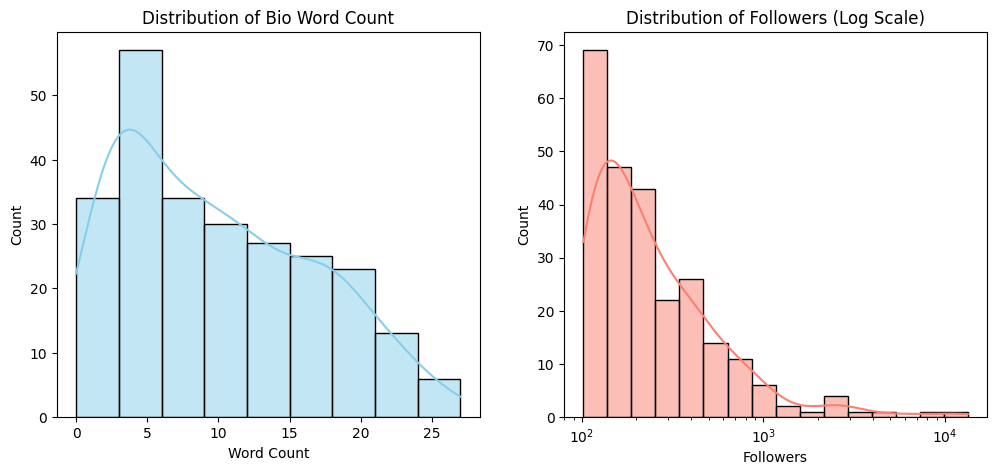

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['bio_word_count'], kde=True, color='skyblue')
plt.title('Distribution of Bio Word Count')
plt.xlabel('Word Count')

plt.subplot(1, 2, 2)
sns.histplot(df['followers'], kde=True, color='salmon', log_scale=True)
plt.title('Distribution of Followers (Log Scale)')
plt.xlabel('Followers')
plt.show()


#Bio Sentiment Analysis

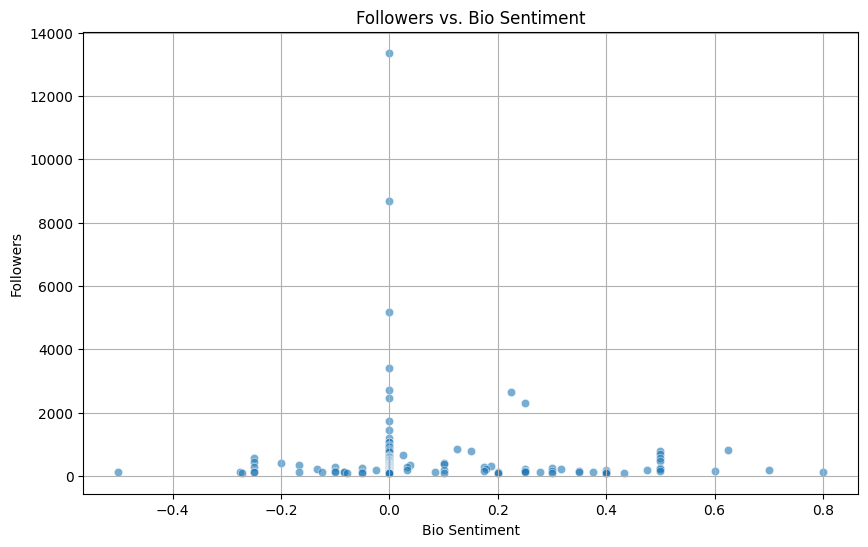

In [ ]:
from textblob import TextBlob

# Calculate sentiment polarity for each bio
df['bio_sentiment'] = df['bio'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Scatter plot of followers vs sentiment
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bio_sentiment', y='followers', data=df, alpha=0.6)
plt.title('Followers vs. Bio Sentiment')
plt.xlabel('Bio Sentiment')
plt.ylabel('Followers')
plt.grid(True)
plt.show()


#Keyword Analysis

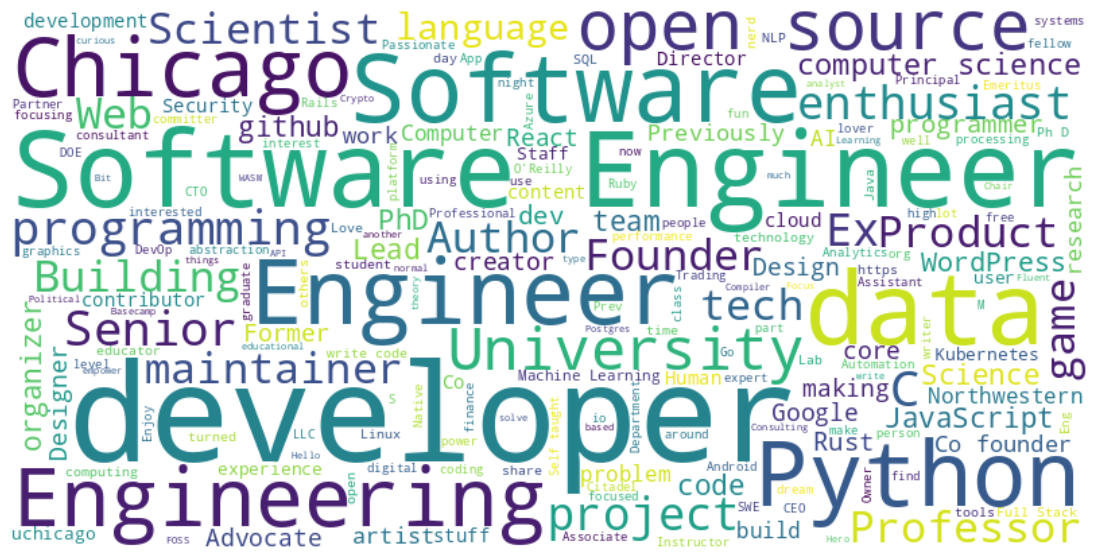

In [ ]:
from wordcloud import WordCloud

# Generate word cloud
all_bios = ' '.join(df['bio'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_bios)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.title('Chicago User Community-Most Common Words in Bio Data')
plt.show()


#User Data Analysis

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone
file_pathu = '/content/drive/My Drive/TDS/users.csv'

def load_and_prepare_data(file_path):
    """Load and prepare the GitHub user data."""
    # Read the CSV file
    df = pd.read_csv(file_pathu)

    # Convert date columns to datetime
    df['created_at'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)

    # Calculate account age in years
    #current_date = datetime.now(timezone.utc)
    df['account_age_years'] = (datetime.now() - df['created_at']).dt.total_seconds() / (365.25 * 24 * 60 * 60)

    return df

def user_engagement_analysis(df):
    """Analyze user engagement metrics."""
    engagement_metrics = {
        'follower_following_ratio': df['followers'] / df['following'],
        'repos_per_year': df['public_repos'] / df['account_age_years'],
        'engagement_rate': df['followers'] / df['account_age_years']
    }

    results = pd.DataFrame(engagement_metrics)
    results['login'] = df['login']
    results.set_index('login', inplace=True)

    return results

def temporal_analysis(df):
    """Analyze temporal patterns."""
    temporal_metrics = {
        'account_creation_year': df['created_at'].dt.year,
        'platform_tenure_years': df['account_age_years'],
        'creation_month': df['created_at'].dt.month,
        'creation_day_of_week': df['created_at'].dt.day_name()
    }

    return pd.DataFrame(temporal_metrics)

def profile_completeness_analysis(df):
    """Analyze profile completeness."""
    completeness = pd.DataFrame()

    # Calculate completeness score
    completeness['has_bio'] = df['bio'].notna()
    completeness['has_email'] = df['email'].notna()
    completeness['has_location'] = df['location'].notna()
    completeness['completeness_score'] = (
        completeness['has_bio'].astype(int) +
        completeness['has_email'].astype(int) +
        completeness['has_location'].astype(int)
    )

    # Add other metrics
    completeness['followers'] = df['followers']
    completeness['hireable'] = df['hireable']

    return completeness

def professional_insights_analysis(df):
    """Analyze professional metrics."""
    professional = pd.DataFrame()

    professional['has_company'] = df['company'].notna()
    professional['hireable'] = df['hireable']
    professional['followers'] = df['followers']
    professional['public_repos'] = df['public_repos']

    return professional

def engagement_metrics_analysis(df):
    """Calculate engagement metrics."""
    metrics = {
        'avg_followers': df['followers'].mean(),
        'median_followers': df['followers'].median(),
        'repo_follower_ratio': (df['public_repos'] / df['followers']).mean(),
        'avg_following': df['following'].mean(),
        'following_std': df['following'].std()
    }

    return pd.Series(metrics)

def generate_report(df):
    """Generate a comprehensive analysis report."""
    report = {}

    # 1. User Engagement Analysis
    engagement = user_engagement_analysis(df)
    report['user_engagement'] = {
        'avg_follower_ratio': engagement['follower_following_ratio'].mean(),
        'avg_repos_per_year': engagement['repos_per_year'].mean(),
        'avg_engagement_rate': engagement['engagement_rate'].mean(),
        'details_by_user': engagement.to_dict(orient='index')
    }

    # 2. Temporal Analysis
    temporal = temporal_analysis(df)
    report['temporal_analysis'] = {
        'avg_tenure': temporal['platform_tenure_years'].mean(),
        'creation_years': temporal['account_creation_year'].value_counts().to_dict(),
        'avg_account_age': temporal['platform_tenure_years'].mean()
    }

    # 3. Profile Completeness
    completeness = profile_completeness_analysis(df)
    report['profile_completeness'] = {
        'avg_completeness': completeness['completeness_score'].mean(),
        'complete_profiles_pct': (completeness['completeness_score'] == 3).mean() * 100,
        'hireable_pct': completeness['hireable'].mean() * 100
    }

    # 4. Professional Insights
    professional = professional_insights_analysis(df)
    report['professional_insights'] = {
        'company_affiliated_pct': professional['has_company'].mean() * 100,
        'avg_repos_by_hireable': professional.groupby('hireable')['public_repos'].mean().to_dict()
    }

    # 5. Engagement Metrics
    engagement_metrics = engagement_metrics_analysis(df)
    report['engagement_metrics'] = engagement_metrics.to_dict()

    return report

def analyze_github_users(file_path):
    """Main function to analyze GitHub user data."""
    # Load and prepare data
    df = load_and_prepare_data(file_path)

    # Generate comprehensive report
    report = generate_report(df)

    # Print formatted results
    print("\n=== GitHub User Analysis Report ===\n")

    print("1. User Engagement Metrics:")
    print(f"- Average Follower/Following Ratio: {report['user_engagement']['avg_follower_ratio']:.2f}")
    print(f"- Average Repositories per Year: {report['user_engagement']['avg_repos_per_year']:.2f}")
    print(f"- Average Engagement Rate: {report['user_engagement']['avg_engagement_rate']:.2f}")

    print("\n2. Temporal Analysis:")
    print(f"- Average Platform Tenure: {report['temporal_analysis']['avg_tenure']:.2f} years")
    print("- Account Creation Years Distribution:", report['temporal_analysis']['creation_years'])

    print("\n3. Profile Completeness:")
    print(f"- Average Completeness Score: {report['profile_completeness']['avg_completeness']:.2f}/3")
    print(f"- Complete Profiles: {report['profile_completeness']['complete_profiles_pct']:.1f}%")
    print(f"- Hireable Status: {report['profile_completeness']['hireable_pct']:.1f}%")

    print("\n4. Professional Insights:")
    print(f"- Company Affiliated: {report['professional_insights']['company_affiliated_pct']:.1f}%")
    print("- Average Repos by Hireable Status:", report['professional_insights']['avg_repos_by_hireable'])

    print("\n5. Engagement Metrics:")
    print(f"- Average Followers: {report['engagement_metrics']['avg_followers']:.2f}")
    print(f"- Repository to Follower Ratio: {report['engagement_metrics']['repo_follower_ratio']:.2f}")
    print(f"- Average Following: {report['engagement_metrics']['avg_following']:.2f}")

    return report

# Example usage:
report = analyze_github_users(file_pathu)


=== GitHub User Analysis Report ===

1. User Engagement Metrics:
- Average Follower/Following Ratio: inf
- Average Repositories per Year: 8.66
- Average Engagement Rate: 37.93

2. Temporal Analysis:
- Average Platform Tenure: 11.89 years
- Account Creation Years Distribution: {2011: 58, 2010: 50, 2012: 44, 2008: 41, 2013: 34, 2009: 29, 2014: 25, 2015: 25, 2017: 17, 2016: 14, 2018: 13, 2019: 11, 2020: 10, 2023: 2, 2024: 1, 2021: 1}

3. Profile Completeness:
- Average Completeness Score: 2.15/3
- Complete Profiles: 34.1%
- Hireable Status: 24.8%

4. Professional Insights:
- Company Affiliated: 57.6%
- Average Repos by Hireable Status: {False: 90.34397163120568, True: 107.87096774193549}

5. Engagement Metrics:
- Average Followers: 391.55
- Repository to Follower Ratio: 0.45
- Average Following: 129.34


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


df = pd.read_csv(file_pathr)
#df['created_at'] = pd.to_datetime(df['created_at'])
df['created_at'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)
# Add derived columns
df['month'] = df['created_at'].dt.month
df['year'] = df['created_at'].dt.year
df['day_of_week'] = df['created_at'].dt.dayofweek
df['hour'] = df['created_at'].dt.hour
df['repository_age_days'] = (datetime.now() - df['created_at']).dt.days
df['full_name'] = df['full_name'].str.split('/').str[1]
df['stars_per_day'] = df['stargazers_count'] / df['repository_age_days']

def analyze_hidden_patterns():
    # 1. Creation Time Analysis
    time_patterns = {
        'hour_distribution': df['hour'].value_counts().sort_index(),
        'day_distribution': df['day_of_week'].value_counts().sort_index(),
        'month_distribution': df['month'].value_counts().sort_index()
    }

    # 2. Repository Naming Analysis
    name_patterns = {
        'avg_name_length': df['full_name'].str.len().mean(),
        'common_words': Counter(" ".join(df['full_name']).lower().split("-")).most_common(5),
        'naming_pattern': df['full_name'].str.contains(r'\d').mean()  # Fraction with numbers
    }

    # 3. Project Configuration Patterns
    config_patterns = {
        'wiki_project_correlation': df.groupby(['has_wiki', 'has_projects']).size(),
        'license_language_correlation': pd.crosstab(df['license_name'].fillna('None'),
                                                  df['language'].fillna('Not Specified'))
    }

    # 4. Success Pattern Analysis
    success_metrics = {
        'stars_vs_age': df.groupby('year')['stargazers_count'].mean(),
        'successful_repos': df[df['stargazers_count'] > df['stargazers_count'].median()],
        'stars_per_day_top': df.nlargest(5, 'stars_per_day')[['full_name', 'stars_per_day', 'created_at']]
    }

    return {
        'time_patterns': time_patterns,
        'name_patterns': name_patterns,
        'config_patterns': config_patterns,
        'success_metrics': success_metrics
    }

# Run analysis
analysis = analyze_hidden_patterns()

# Print insights
print("Hidden Pattern Insights:\n")

print("1. Repository Creation Patterns:")
print(f"- Most active creation hour: {df['hour'].mode().iloc[0]}:00")
print(f"- Most active day of week: {['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][df['day_of_week'].mode().iloc[0]]}")
print(f"- Most active month: {df['month'].mode().iloc[0]}")

print("\n2. Repository Naming Patterns:")
print(f"- Average repository name length: {analysis['name_patterns']['avg_name_length']:.1f} characters")
print("- Most common words in names:", analysis['name_patterns']['common_words'])

print("\n3. Project Success Patterns:")
print("Top repositories by stars per day:")
print(analysis['success_metrics']['stars_per_day_top'])

print("\n4. Configuration Patterns:")
print("Wiki and Project settings correlation:")
print(analysis['config_patterns']['wiki_project_correlation'])

Hidden Pattern Insights:

1. Repository Creation Patterns:
- Most active creation hour: 19:00
- Most active day of week: Tue
- Most active month: 1

2. Repository Naming Patterns:
- Average repository name length: 13.9 characters
- Most common words in names: [('to', 160), ('for', 131), ('data', 126), ('and', 120), ('with', 115)]

3. Project Success Patterns:
Top repositories by stars per day:
                         full_name  stars_per_day          created_at
3031                        omakub      34.202614 2024-05-25 20:51:27
4979                python-mastery      22.875803 2023-07-17 01:11:15
4938           awesome-flipperzero      19.498433 2022-03-14 11:28:59
2995                         kamal      17.139818 2023-01-07 14:32:08
12489  Dreambooth-Stable-Diffusion       9.722151 2022-09-06 06:57:40

4. Configuration Patterns:
Wiki and Project settings correlation:
has_wiki  has_projects
False     False             623
          True             4585
True      False             1

<ipython-input-21-7e9867ce9236>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


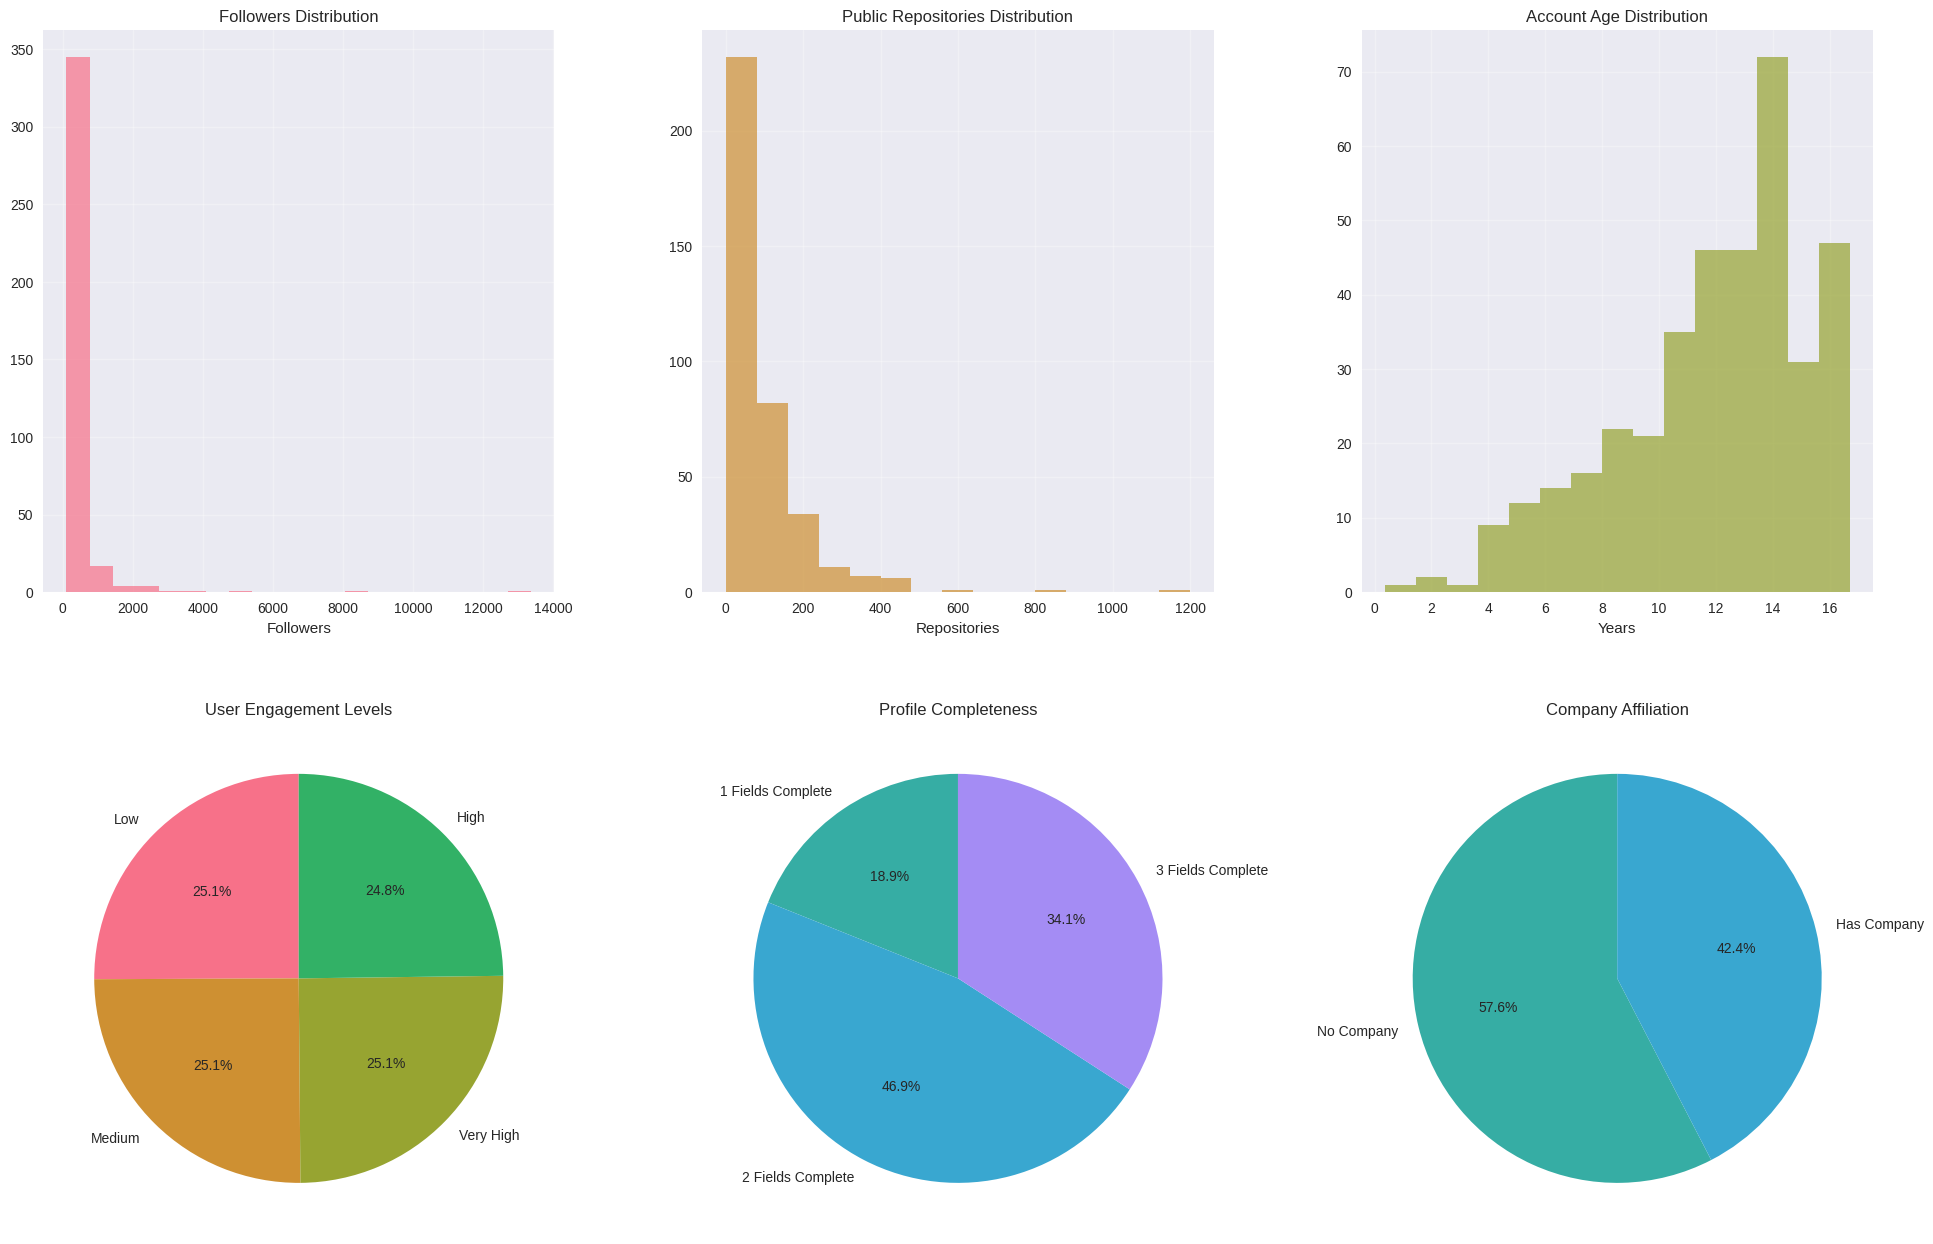

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone

class GitHubVisualizationAnalyzer:
    def __init__(self, file_path):
        self.df = self.load_and_prepare_data(file_path)
        # Set style for better-looking plots
        plt.style.use('seaborn')
        self.colors = sns.color_palette("husl", 8)

    def load_and_prepare_data(self, file_path):
        """Load and prepare the GitHub user data."""
        df = pd.read_csv(file_path)
        df['created_at'] = pd.to_datetime(df['created_at'])
        current_date = datetime.now(timezone.utc)
        df['account_age_years'] = (current_date - df['created_at']).dt.total_seconds() / (365.25 * 24 * 60 * 60)
        return df

    def plot_follower_distribution(self):
        """Create histogram of follower distribution."""
        plt.figure(figsize=(10, 6))
        plt.hist(self.df['followers'], bins=20, color=self.colors[0], alpha=0.7)
        plt.title('Distribution of GitHub Followers')
        plt.xlabel('Number of Followers')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        return plt.gcf()

    def plot_repository_distribution(self):
        """Create histogram of public repositories."""
        plt.figure(figsize=(10, 6))
        plt.hist(self.df['public_repos'], bins=15, color=self.colors[1], alpha=0.7)
        plt.title('Distribution of Public Repositories')
        plt.xlabel('Number of Public Repositories')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        return plt.gcf()

    def plot_engagement_metrics_pie(self):
        """Create pie chart of engagement levels."""
        plt.figure(figsize=(10, 10))
        # Calculate engagement score based on followers and repos
        engagement_score = self.df['followers'] * 0.7 + self.df['public_repos'] * 0.3
        engagement_levels = pd.qcut(engagement_score, q=4, labels=['Low', 'Medium', 'High', 'Very High'])
        engagement_dist = engagement_levels.value_counts()

        plt.pie(engagement_dist, labels=engagement_dist.index, autopct='%1.1f%%',
                colors=self.colors[:4], startangle=90)
        plt.title('Distribution of User Engagement Levels')
        return plt.gcf()

    def plot_profile_completeness_pie(self):
        """Create pie chart of profile completeness."""
        plt.figure(figsize=(10, 10))
        completeness = pd.DataFrame()
        completeness['has_bio'] = self.df['bio'].notna()
        completeness['has_email'] = self.df['email'].notna()
        completeness['has_location'] = self.df['location'].notna()

        completeness_score = (completeness['has_bio'].astype(int) +
                            completeness['has_email'].astype(int) +
                            completeness['has_location'].astype(int))

        score_dist = completeness_score.value_counts().sort_index()
        plt.pie(score_dist, labels=[f'{i} Fields Complete' for i in score_dist.index],
                autopct='%1.1f%%', colors=self.colors[4:], startangle=90)
        plt.title('Profile Completeness Distribution')
        return plt.gcf()

    def plot_account_age_histogram(self):
        """Create histogram of account ages."""
        plt.figure(figsize=(10, 6))
        plt.hist(self.df['account_age_years'], bins=15, color=self.colors[2], alpha=0.7)
        plt.title('Distribution of Account Ages')
        plt.xlabel('Account Age (Years)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        return plt.gcf()

    def plot_following_distribution(self):
        """Create histogram of following counts."""
        plt.figure(figsize=(10, 6))
        plt.hist(self.df['following'], bins=15, color=self.colors[3], alpha=0.7)
        plt.title('Distribution of Following Counts')
        plt.xlabel('Number of Users Following')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        return plt.gcf()

    def plot_hireable_status_pie(self):
        """Create pie chart of hireable status."""
        plt.figure(figsize=(10, 10))
        hireable_dist = self.df['hireable'].value_counts()
        plt.pie(hireable_dist, labels=['Not Hireable', 'Hireable'],
                autopct='%1.1f%%', colors=[self.colors[6], self.colors[7]], startangle=90)
        plt.title('Distribution of Hireable Status')
        return plt.gcf()

    def plot_company_affiliation_pie(self):
        """Create pie chart of company affiliation."""
        plt.figure(figsize=(10, 10))
        has_company = self.df['company'].notna()
        company_dist = has_company.value_counts()
        plt.pie(company_dist, labels=['No Company Listed', 'Company Listed'],
                autopct='%1.1f%%', colors=[self.colors[4], self.colors[5]], startangle=90)
        plt.title('Company Affiliation Distribution')
        return plt.gcf()

    def create_all_visualizations(self):
        """Create and display all visualizations."""
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 20))

        # Histograms
        plt.subplot(3, 3, 1)
        plt.hist(self.df['followers'], bins=20, color=self.colors[0], alpha=0.7)
        plt.title('Followers Distribution')
        plt.xlabel('Followers')
        plt.grid(True, alpha=0.3)

        plt.subplot(3, 3, 2)
        plt.hist(self.df['public_repos'], bins=15, color=self.colors[1], alpha=0.7)
        plt.title('Public Repositories Distribution')
        plt.xlabel('Repositories')
        plt.grid(True, alpha=0.3)

        plt.subplot(3, 3, 3)
        plt.hist(self.df['account_age_years'], bins=15, color=self.colors[2], alpha=0.7)
        plt.title('Account Age Distribution')
        plt.xlabel('Years')
        plt.grid(True, alpha=0.3)

        # Pie Charts
        # Engagement Levels
        plt.subplot(3, 3, 4)
        engagement_score = self.df['followers'] * 0.7 + self.df['public_repos'] * 0.3
        engagement_levels = pd.qcut(engagement_score, q=4, labels=['Low', 'Medium', 'High', 'Very High'])
        engagement_dist = engagement_levels.value_counts()
        plt.pie(engagement_dist, labels=engagement_dist.index, autopct='%1.1f%%',
                colors=self.colors[:4], startangle=90)
        plt.title('User Engagement Levels')

        # Profile Completeness
        plt.subplot(3, 3, 5)
        completeness = pd.DataFrame()
        completeness['has_bio'] = self.df['bio'].notna()
        completeness['has_email'] = self.df['email'].notna()
        completeness['has_location'] = self.df['location'].notna()
        completeness_score = (completeness['has_bio'].astype(int) +
                            completeness['has_email'].astype(int) +
                            completeness['has_location'].astype(int))
        score_dist = completeness_score.value_counts().sort_index()
        plt.pie(score_dist, labels=[f'{i} Fields Complete' for i in score_dist.index],
                autopct='%1.1f%%', colors=self.colors[4:], startangle=90)
        plt.title('Profile Completeness')

        # Company Affiliation
        plt.subplot(3, 3, 6)
        has_company = self.df['company'].notna()
        company_dist = has_company.value_counts()
        plt.pie(company_dist, labels=['No Company', 'Has Company'],
                autopct='%1.1f%%', colors=[self.colors[4], self.colors[5]], startangle=90)
        plt.title('Company Affiliation')

        plt.tight_layout(pad=3.0)
        return fig

def analyze_github_data(file_path):
    """Main function to analyze GitHub data and create visualizations."""
    analyzer = GitHubVisualizationAnalyzer(file_path)

    # Create all visualizations
    fig = analyzer.create_all_visualizations()

    # Display the figure
    plt.show()

    return analyzer.df, fig

# Example usage:
df, fig = analyze_github_data(file_pathu)


Oldest Account: login                                           ELLIOTTCABLE
name                                                     NaN
company                                               AHREFS
location                                         Chicago, IL
email                                  github-public@from.ec
hireable                                                True
bio                    {PL,Q}T. Accidental creator of @Paws.
public_repos                                             243
followers                                                442
following                                                826
created_at                               2008-02-13 03:27:01
days_since_creation                                     6100
Name: 66, dtype: object
Newest Account: login                                                          khanovico
name                                                        Joseph Mitch
company                                               KEY2MOON SOL

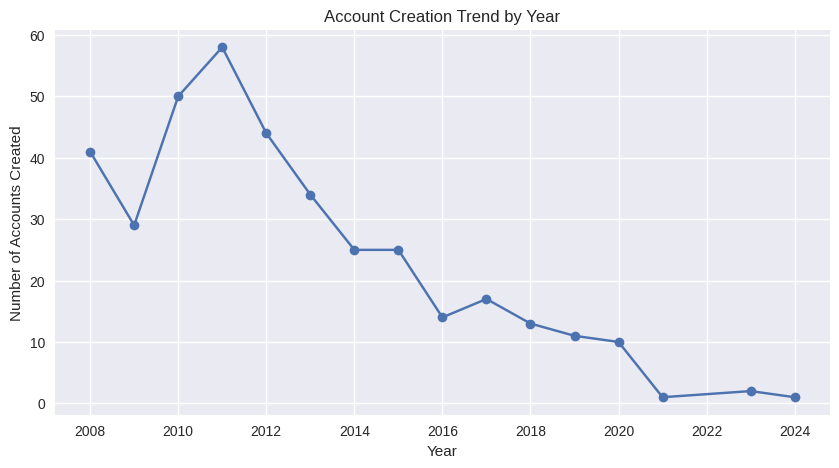

Correlations:
               followers  following  public_repos
followers      1.000000   0.032839      0.082159
following      0.032839   1.000000      0.129014
public_repos   0.082159   0.129014      1.000000
Company-Wide Stats:
                                      avg_followers  avg_public_repos  \
company                                                                
.TXT                                         250.0             154.0   
10UP                                         166.0              48.0   
1DEBIT                                       114.0              58.0   
ACTIVECAMPAIGN                               156.0              70.5   
ACTIVECAMPAIGN, @R-SHIEF AND OTHERS          159.0             345.0   
...                                            ...               ...   
Y O L K                                      192.0             615.0   
ZAPIER                                       211.0               7.0   
ZIGUROUS                                     155

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Load data from CSV
df = pd.read_csv(file_pathu)

# Convert 'created_at' to datetime
df['created_at'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)

# 1. User Growth Analysis
# Days since account creation
df['days_since_creation'] = (datetime.now() - df['created_at']).dt.days
# Find oldest and newest accounts
oldest_account = df.loc[df['created_at'].idxmin()]
newest_account = df.loc[df['created_at'].idxmax()]

print("Oldest Account:", oldest_account)
print("Newest Account:", newest_account)

# 2. Engagement Metrics
# Follower-to-following ratio
df['follower_following_ratio'] = df['followers'] / df['following'].replace(0, np.nan)

# Rank users by followers
df['follower_rank'] = df['followers'].rank(ascending=False)

# 3. Company and Location Breakdown
# Count by company and location
company_count = df['company'].value_counts()
location_count = df['location'].value_counts()

print("Company Count:\n", company_count)
print("Location Count:\n", location_count)

# 4. Hiring Analysis
# Filter hireable users
hireable_users = df[df['hireable'] == True]
print("Hireable Users:\n", hireable_users)

# 5. Text Analysis on Bio (for keyword "Python")
# Check if "Python" is mentioned in bio
df['mentions_python'] = df['bio'].str.contains('Python', case=False, na=False)
python_mention_count = df['mentions_python'].sum()

print("Users mentioning Python in bio:", python_mention_count)

# 6. Time Series Analysis (account creation trend by year)
df['year_created'] = df['created_at'].dt.year
creation_trend = df['year_created'].value_counts().sort_index()

# Plot account creation trend
plt.figure(figsize=(10, 5))
creation_trend.plot(kind='line', marker='o')
plt.title('Account Creation Trend by Year')
plt.xlabel('Year')
plt.ylabel('Number of Accounts Created')
plt.show()

# 7. Correlations Between Variables
# Calculate correlation between followers, following, and public repos
correlations = df[['followers', 'following', 'public_repos']].corr()
print("Correlations:\n", correlations)

# 8. Activity Metrics
# Followers per year since account creation
df['years_since_creation'] = (datetime.now() - df['created_at']).dt.days / 365
df['followers_per_year'] = df['followers'] / df['years_since_creation'].replace(0, np.nan)

# 9. Company-Wide Stats
# Group by company and calculate average followers, public_repos, and following
company_stats = df.groupby('company').agg({
    'followers': 'mean',
    'public_repos': 'mean',
    'following': 'mean'
}).rename(columns={
    'followers': 'avg_followers',
    'public_repos': 'avg_public_repos',
    'following': 'avg_following'
})

print("Company-Wide Stats:\n", company_stats)

# Optional: Save analysis to a new CSV
df.to_csv('analysis_results.csv', index=False)


#Top 20 Key words in the Bio

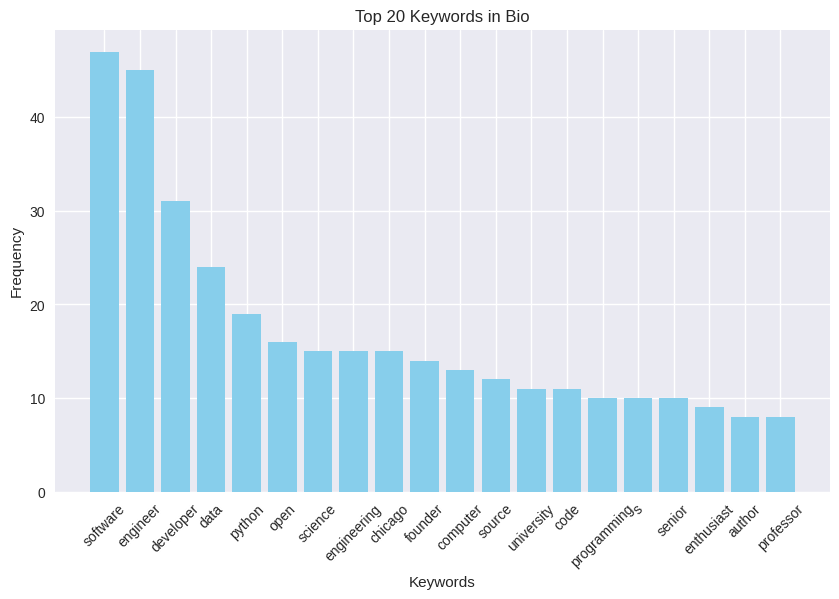

('software', 'engineer', 'developer', 'data', 'python', 'open', 'science', 'engineering', 'chicago', 'founder', 'computer', 'source', 'university', 'code', 'programming', 's', 'senior', 'enthusiast', 'author', 'professor')


In [ ]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

# Load data from CSV
df = pd.read_csv(file_pathu)

# Step 1: Extract the 'bio' column (or 'CV' if it exists)
# Assuming 'bio' column contains the relevant text
text_data = df['bio'].dropna().str.lower()  # Convert to lowercase to avoid case sensitivity

# Step 2: Clean and tokenize the text
# Remove non-alphabet characters and split words
words = []
for bio in text_data:
    # Remove special characters and split into words
    tokens = re.findall(r'\b\w+\b', bio)  # Finds words by matching word boundaries
    words.extend(tokens)

# Step 3: Count word occurrences
# Use Counter to count the frequency of each word
word_counts = Counter(words)

# Step 4: Remove common stopwords (e.g., 'the', 'and', 'is', etc.)
# Define a list of common English stopwords
stopwords = set([
    'and', 'the', 'of', 'to', 'a', 'in', 'for', 'with', 'on', 'by', 'at',
    'from', 'that', 'as', 'or', 'it', 'is', 'this', 'be', 'an','i','co','my','ex'
])
# Remove stopwords from the counter
filtered_word_counts = {word: count for word, count in word_counts.items() if word not in stopwords}

# Step 5: Get the top 10 most common keywords
top_10_keywords = Counter(filtered_word_counts).most_common(20)
keywords, counts = zip(*top_10_keywords)  # Separate keywords and counts for plotting

# Step 6: Plot the results
plt.figure(figsize=(10, 6))
plt.bar(keywords, counts, color='skyblue')
plt.title('Top 20 Keywords in Bio')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
print (keywords)


# Repository Analysis

      login           full_name            created_at  stargazers_count  \
0  cassidoo  cassidoo/accordion  2020-01-23T13:19:32Z                17   
1  cassidoo      cassidoo/agagd  2023-11-20T05:21:51Z                 1   
2  cassidoo        cassidoo/ama  2020-06-09T02:22:18Z                62   
3  cassidoo    cassidoo/ASL2048  2014-03-20T14:29:23Z                 0   
4  cassidoo      cassidoo/astro  2021-09-14T06:35:07Z                 0   

   watchers_count    language  has_projects  has_wiki license_name  
0              17  JavaScript          True      True          NaN  
1               1         NaN          True     False  MIT License  
2              62         NaN         False     False          NaN  
3               0         CSS          True      True  MIT License  
4               0         NaN          True     False        Other  
Top 5 repositories by stargazers:
                         full_name  stargazers_count
13365               greensock/GSAP             1

<ipython-input-37-834f77b6418e>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='stargazers_count', y='full_name', data=top_stars, palette='viridis')


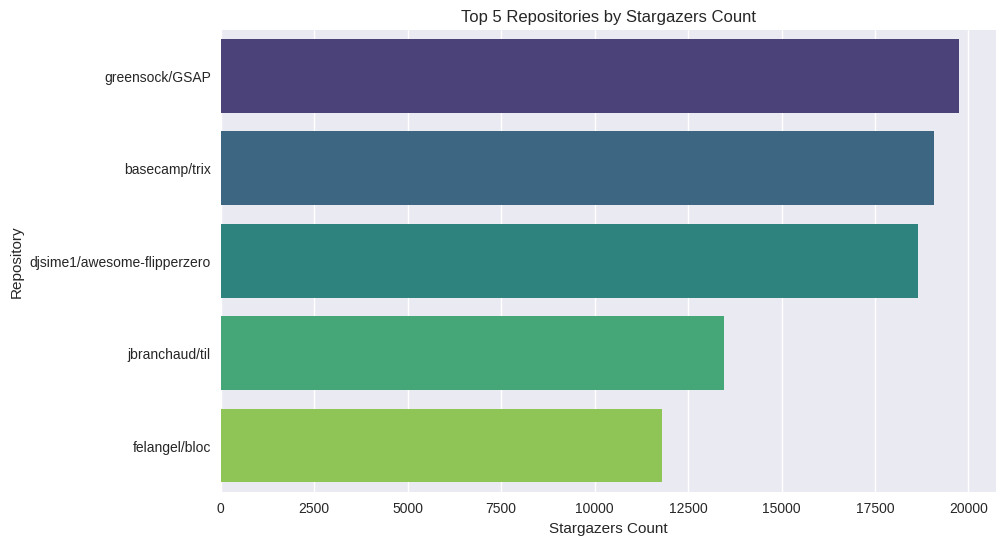

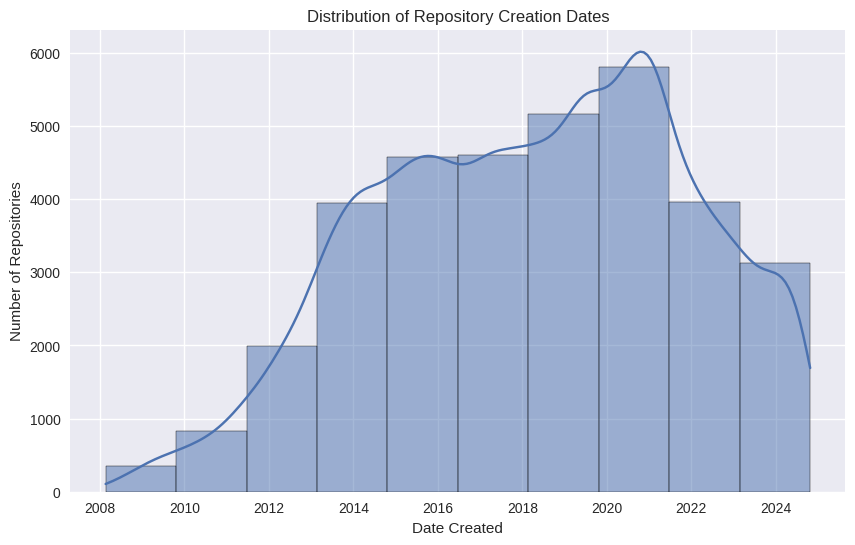

Top 5 languages by number of repositories:
language
JavaScript    5452
Python        3597
Ruby          2339
HTML          1601
Shell         1117
Name: count, dtype: int64


<ipython-input-37-834f77b6418e>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_popularity.values, y=language_popularity.index, palette='coolwarm')


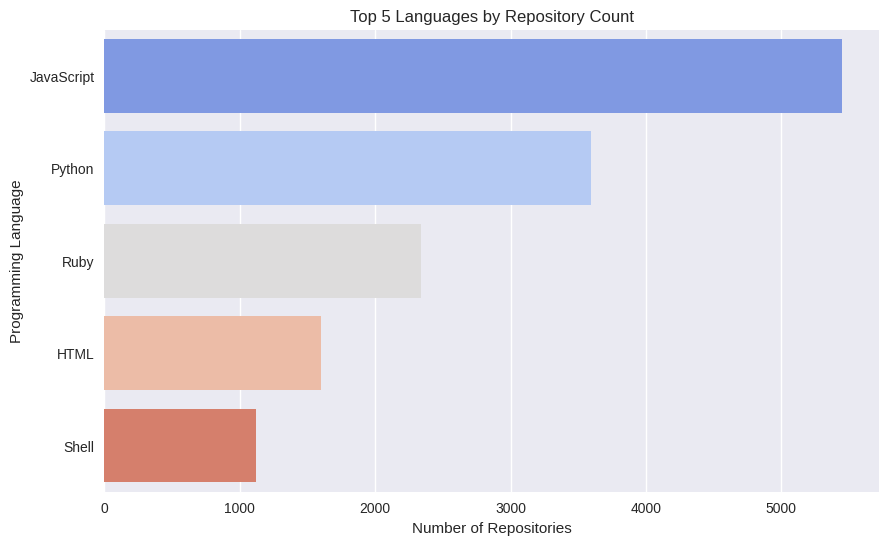

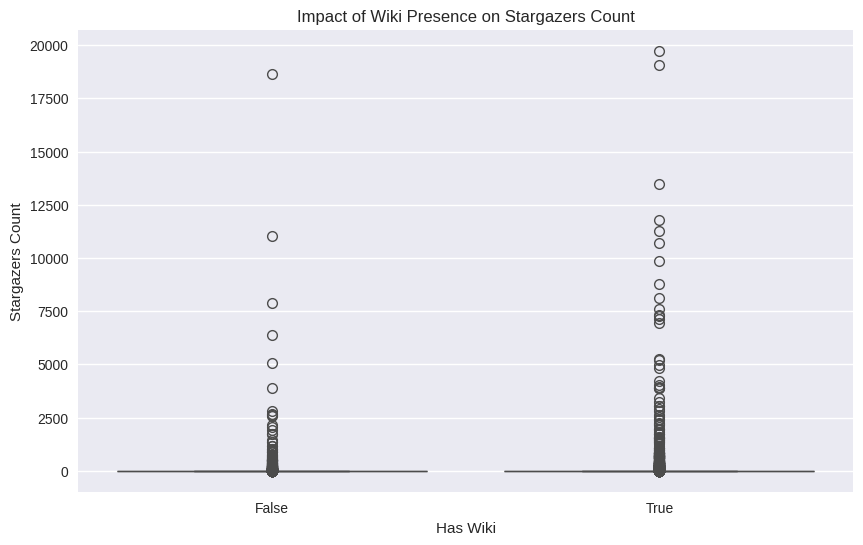

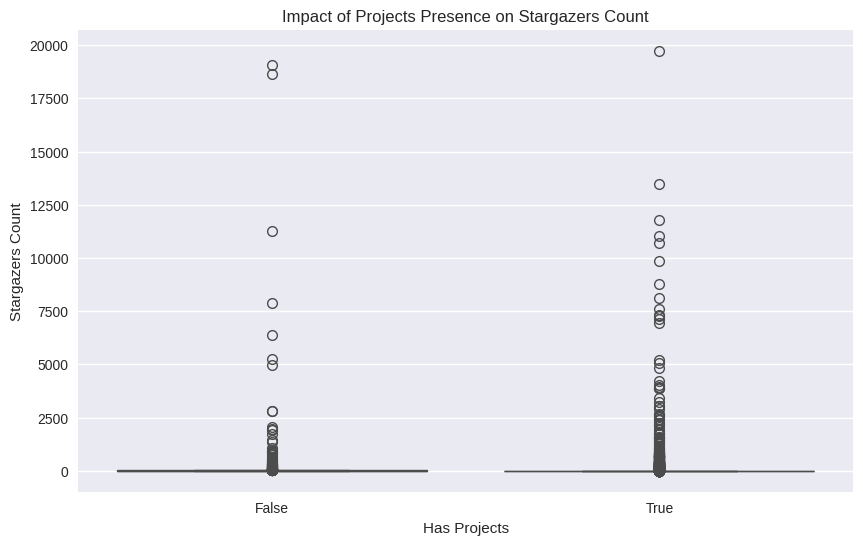

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv(file_pathr)

# Check the structure of the data
print(df.head())

# Convert 'created_at' and 'DateCreated' to datetime format
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['created_at'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)
df['DateCreated'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)
#df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%d/%m/%Y', errors='coerce')
# 1. Top Repositories by Stargazers Count
top_stars = df[['full_name', 'stargazers_count']].sort_values(by='stargazers_count', ascending=False).head(5)
print("Top 5 repositories by stargazers:")
print(top_stars)

# Plot Top 5 Repositories by Stargazers Count
plt.figure(figsize=(10, 6))
sns.barplot(x='stargazers_count', y='full_name', data=top_stars, palette='viridis')
plt.title('Top 5 Repositories by Stargazers Count')
plt.xlabel('Stargazers Count')
plt.ylabel('Repository')
plt.show()

# 2. Distribution of Repository Creation Dates
plt.figure(figsize=(10, 6))
sns.histplot(df['DateCreated'].dropna(), bins=10, kde=True)
plt.title('Distribution of Repository Creation Dates')
plt.xlabel('Date Created')
plt.ylabel('Number of Repositories')
plt.show()

# 3. Popularity of Languages
language_popularity = df['language'].value_counts().head(5)
print("Top 5 languages by number of repositories:")
print(language_popularity)

# Plot Language Popularity
plt.figure(figsize=(10, 6))
sns.barplot(x=language_popularity.values, y=language_popularity.index, palette='coolwarm')
plt.title('Top 5 Languages by Repository Count')
plt.xlabel('Number of Repositories')
plt.ylabel('Programming Language')
plt.show()

# 4. Impact of Wiki and Projects on Stargazers Count
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_wiki', y='stargazers_count', data=df)
plt.title('Impact of Wiki Presence on Stargazers Count')
plt.xlabel('Has Wiki')
plt.ylabel('Stargazers Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='has_projects', y='stargazers_count', data=df)
plt.title('Impact of Projects Presence on Stargazers Count')
plt.xlabel('Has Projects')
plt.ylabel('Stargazers Count')
plt.show()


# Trend of Language

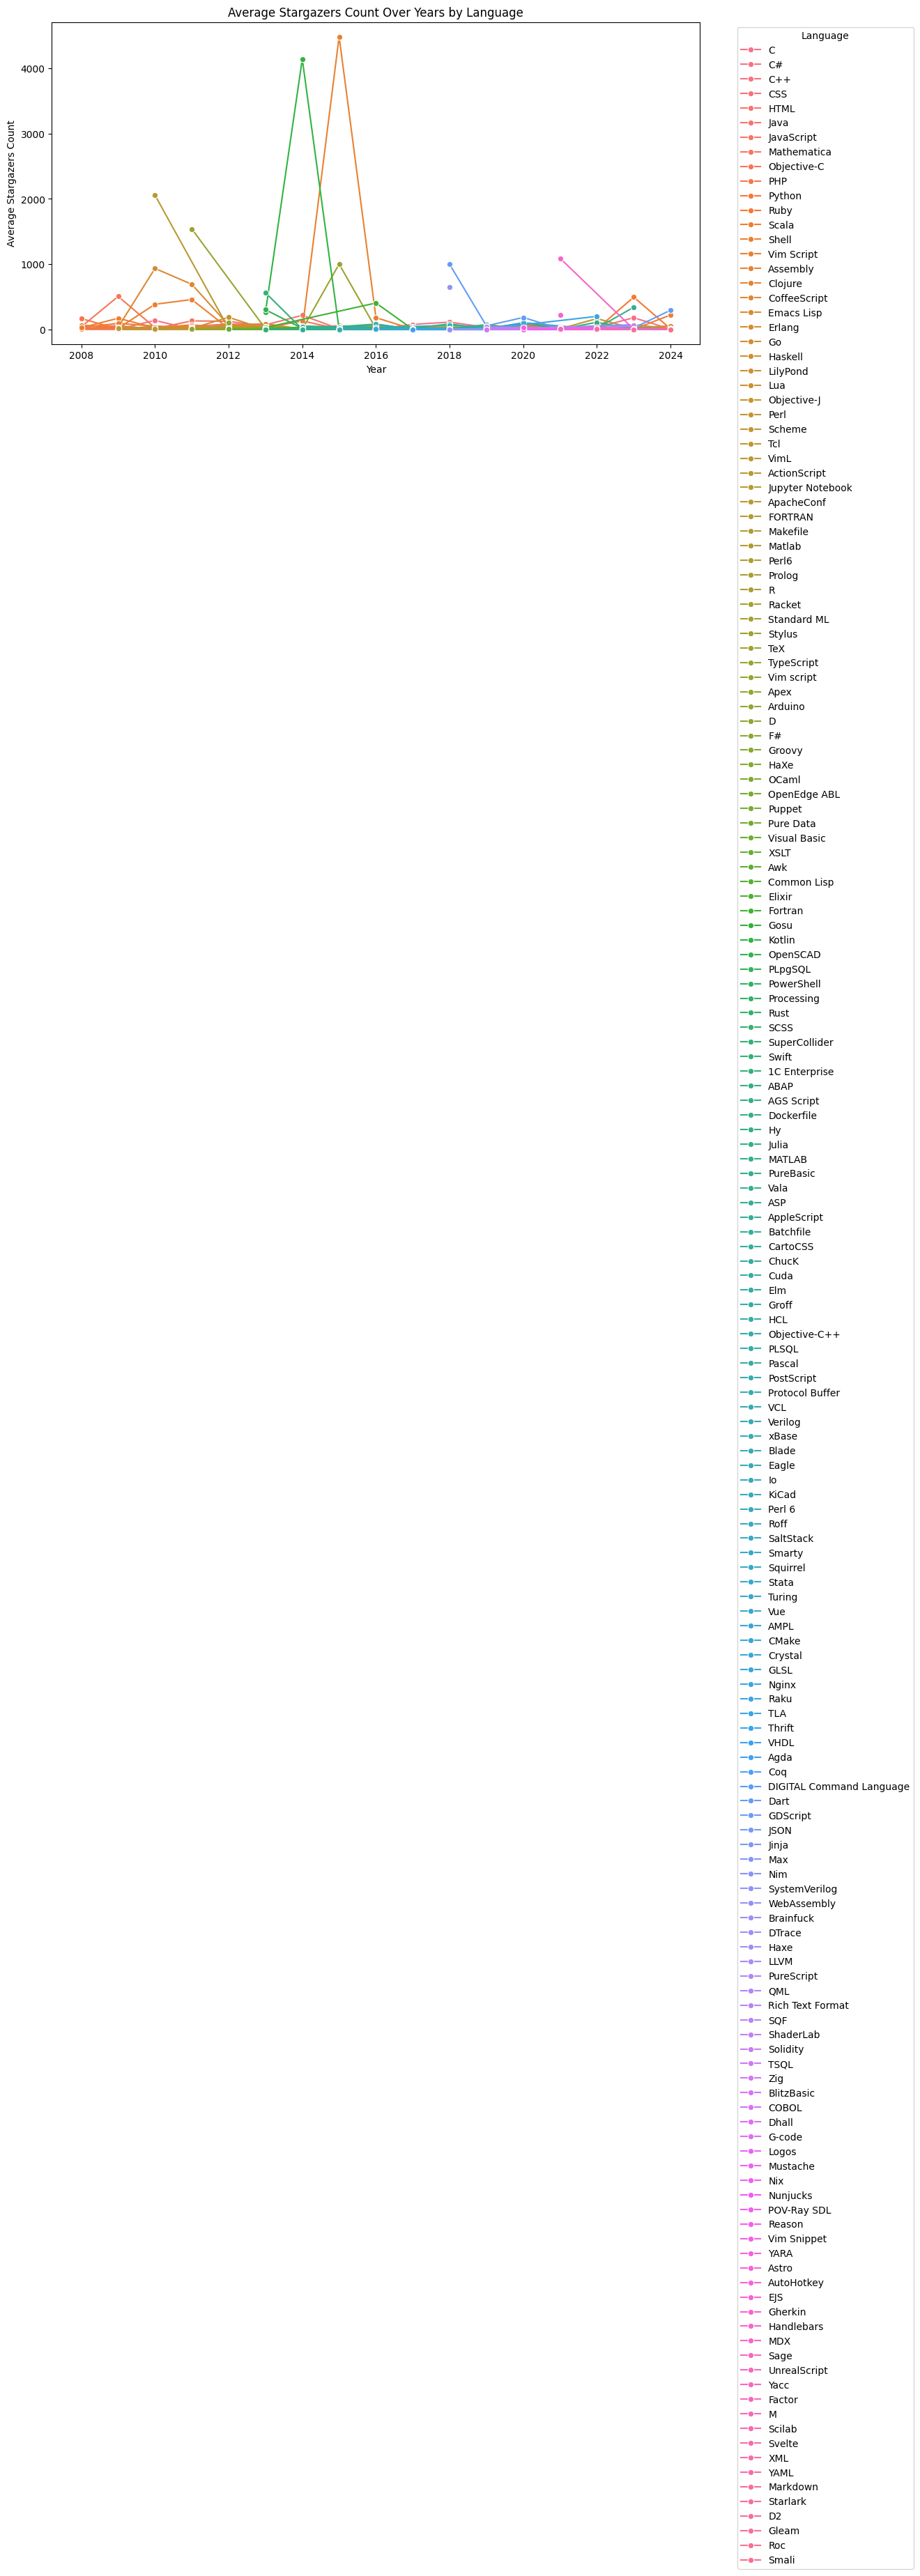

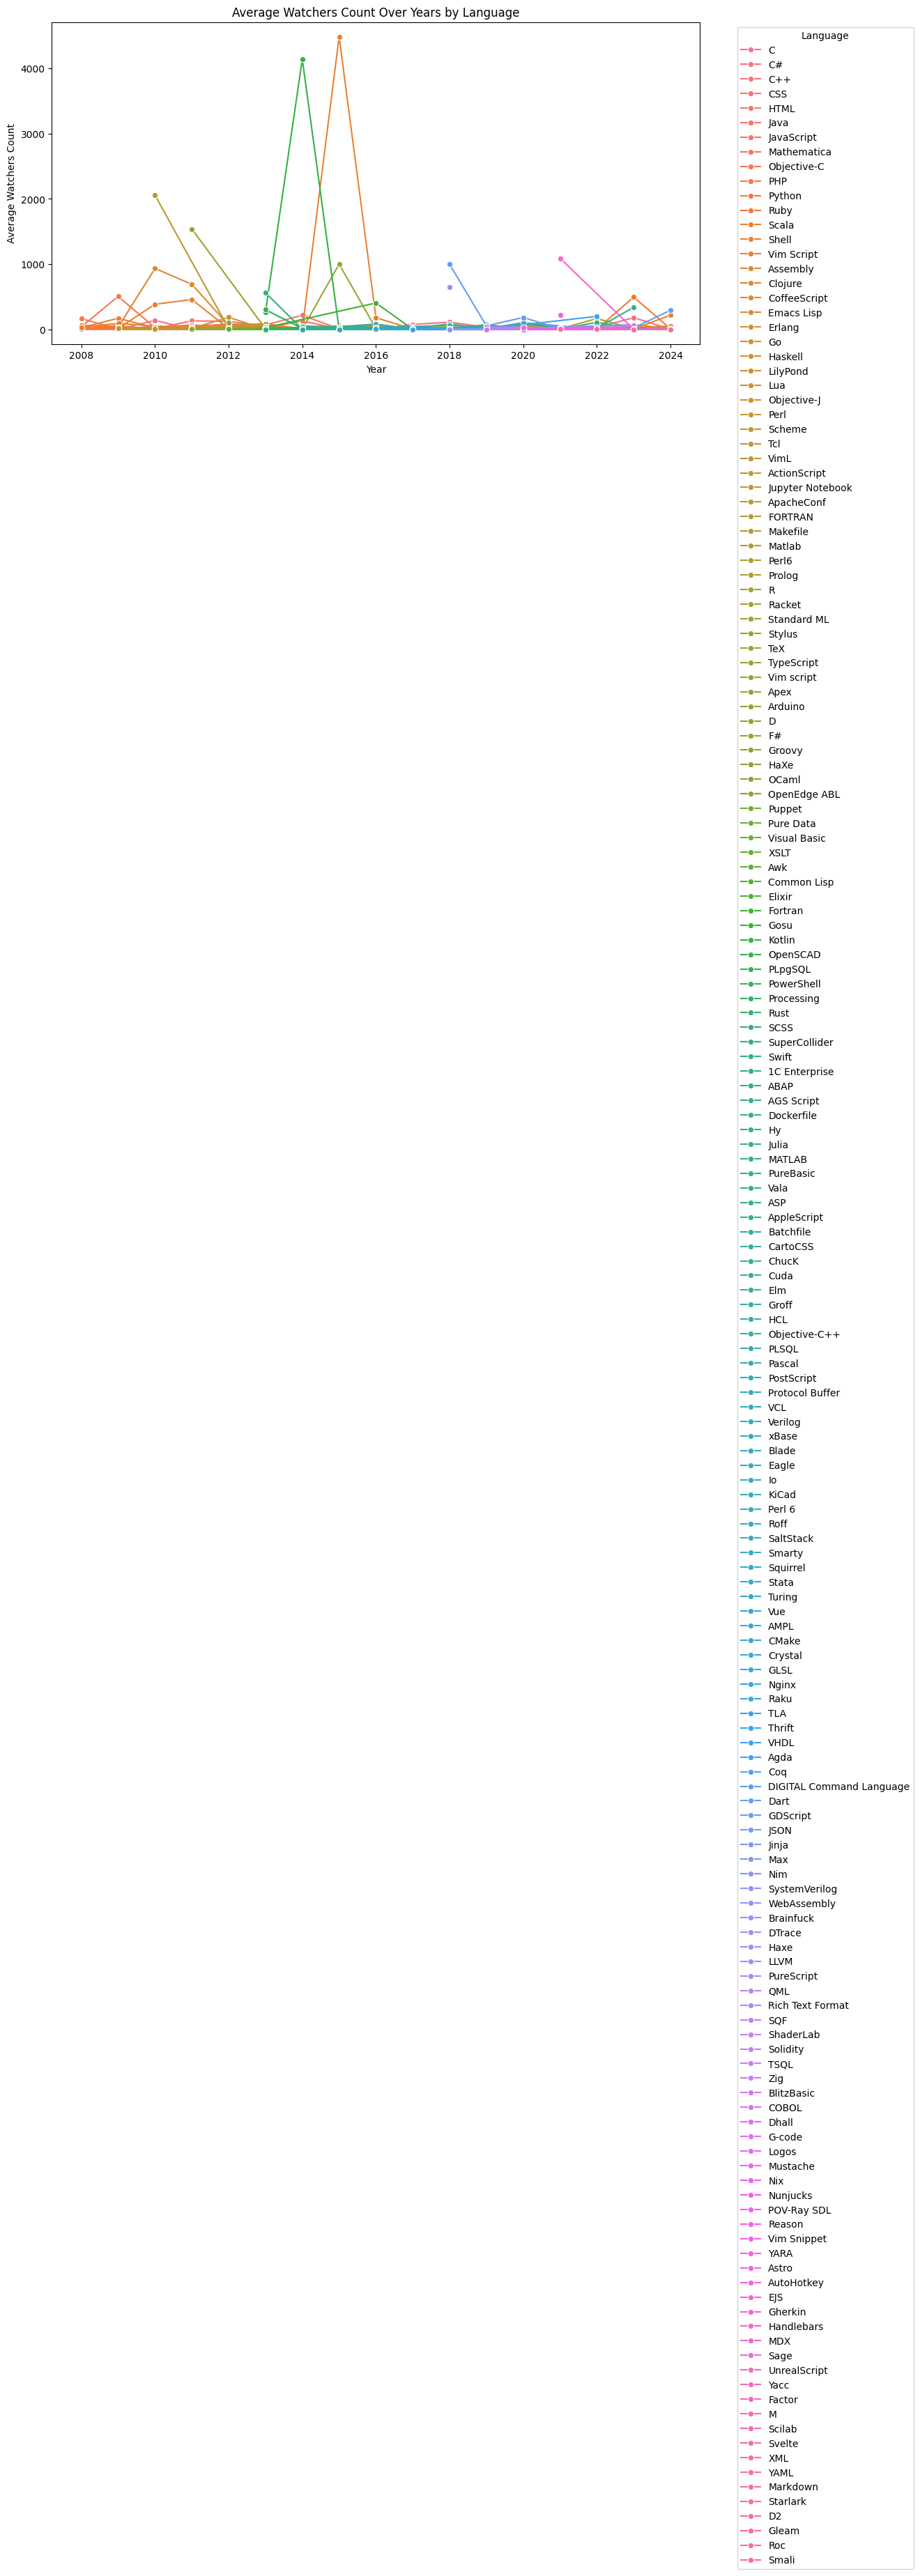

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv(file_pathr)

# Convert 'created_at' to datetime format to extract the year
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['created_at'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)
df['year'] = df['created_at'].dt.year


# Drop rows with missing 'language' or 'year' values
df = df.dropna(subset=['language', 'year'])

# Group by year and language, then calculate the mean stargazers and watchers count
language_trend = df.groupby(['year', 'language']).agg({
    'stargazers_count': 'mean',
    'watchers_count': 'mean'
}).reset_index()

# Plot the trend for stargazers count over the years per language
plt.figure(figsize=(12, 6))
sns.lineplot(data=language_trend, x='year', y='stargazers_count', hue='language', marker='o')
plt.title('Average Stargazers Count Over Years by Language')
plt.xlabel('Year')
plt.ylabel('Average Stargazers Count')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot the trend for watchers count over the years per language
plt.figure(figsize=(12, 6))
sns.lineplot(data=language_trend, x='year', y='watchers_count', hue='language', marker='o')
plt.title('Average Watchers Count Over Years by Language')
plt.xlabel('Year')
plt.ylabel('Average Watchers Count')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


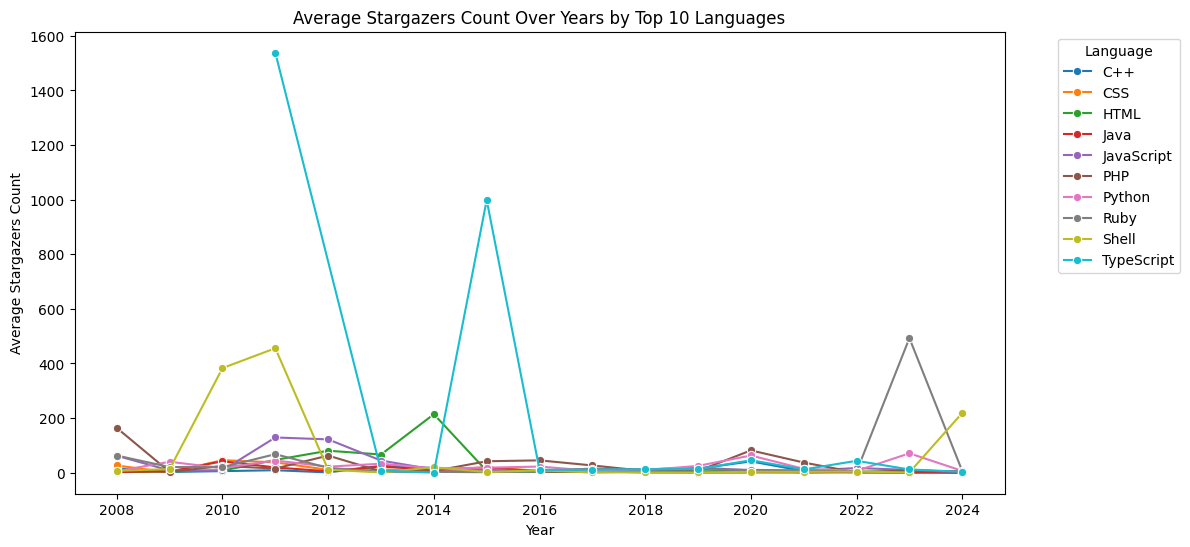

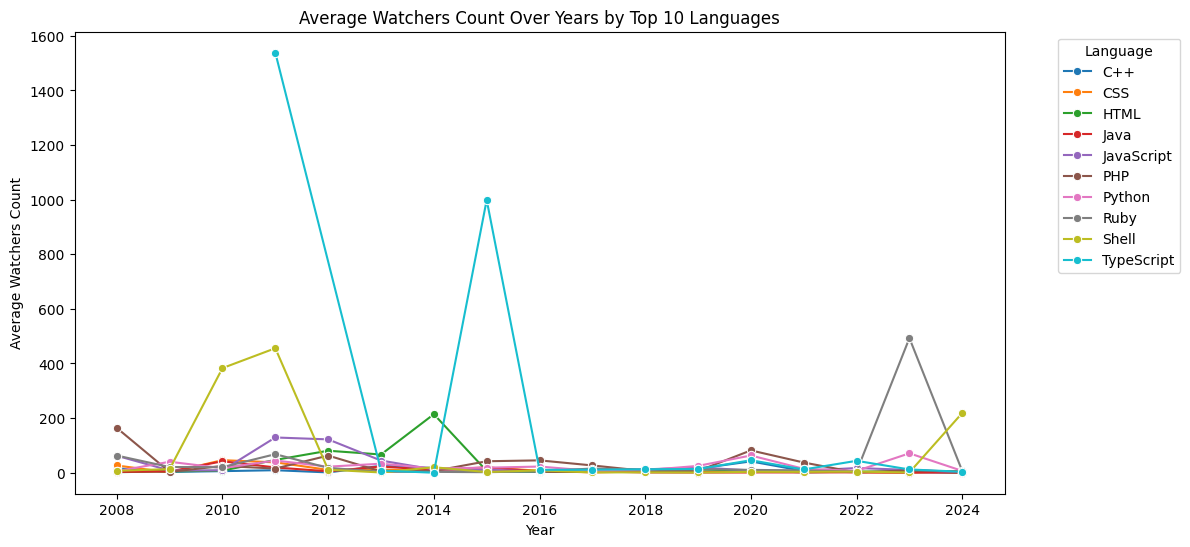

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv(file_pathr)

# Convert 'created_at' to datetime format to extract the year
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['created_at'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)
df['year'] = df['created_at'].dt.year

# Drop rows with missing 'language' or 'year' values
df = df.dropna(subset=['language', 'year'])

# Find the top 10 languages by the number of repositories
top_languages = df['language'].value_counts().head(10).index

# Filter the data to include only the top 10 languages
df_top_languages = df[df['language'].isin(top_languages)]

# Group by year and language, then calculate the mean stargazers and watchers count
language_trend = df_top_languages.groupby(['year', 'language']).agg({
    'stargazers_count': 'mean',
    'watchers_count': 'mean'
}).reset_index()

# Plot the trend for stargazers count over the years per language (Top 10 languages only)
plt.figure(figsize=(12, 6))
sns.lineplot(data=language_trend, x='year', y='stargazers_count', hue='language', marker='o')
plt.title('Average Stargazers Count Over Years by Top 10 Languages')
plt.xlabel('Year')
plt.ylabel('Average Stargazers Count')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot the trend for watchers count over the years per language (Top 10 languages only)
plt.figure(figsize=(12, 6))
sns.lineplot(data=language_trend, x='year', y='watchers_count', hue='language', marker='o')
plt.title('Average Watchers Count Over Years by Top 10 Languages')
plt.xlabel('Year')
plt.ylabel('Average Watchers Count')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Number of Repositories Created Over Years by Top 10 Languages


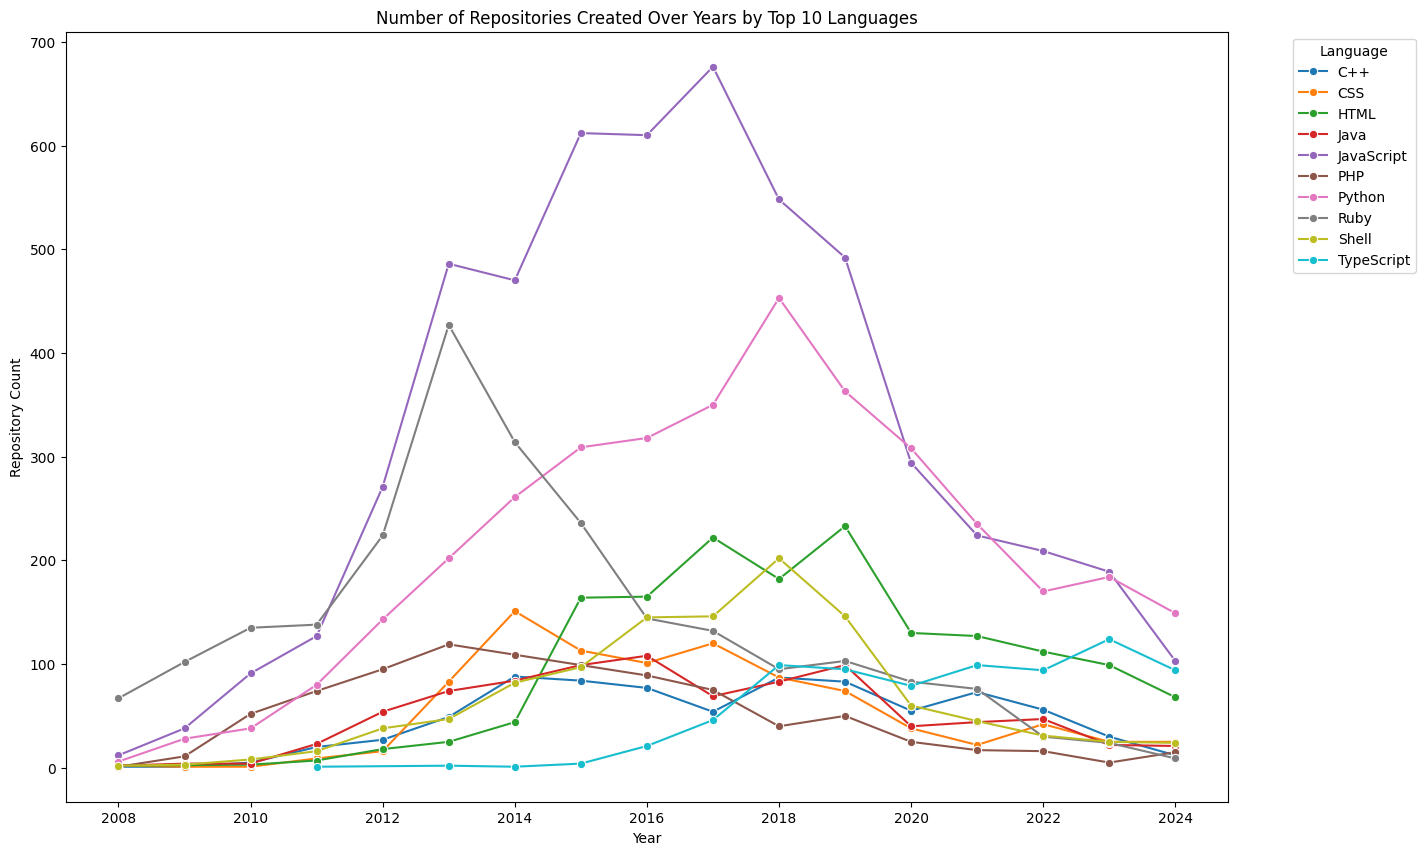

Average Stargazers Count Over Years by Top 10 Languagess


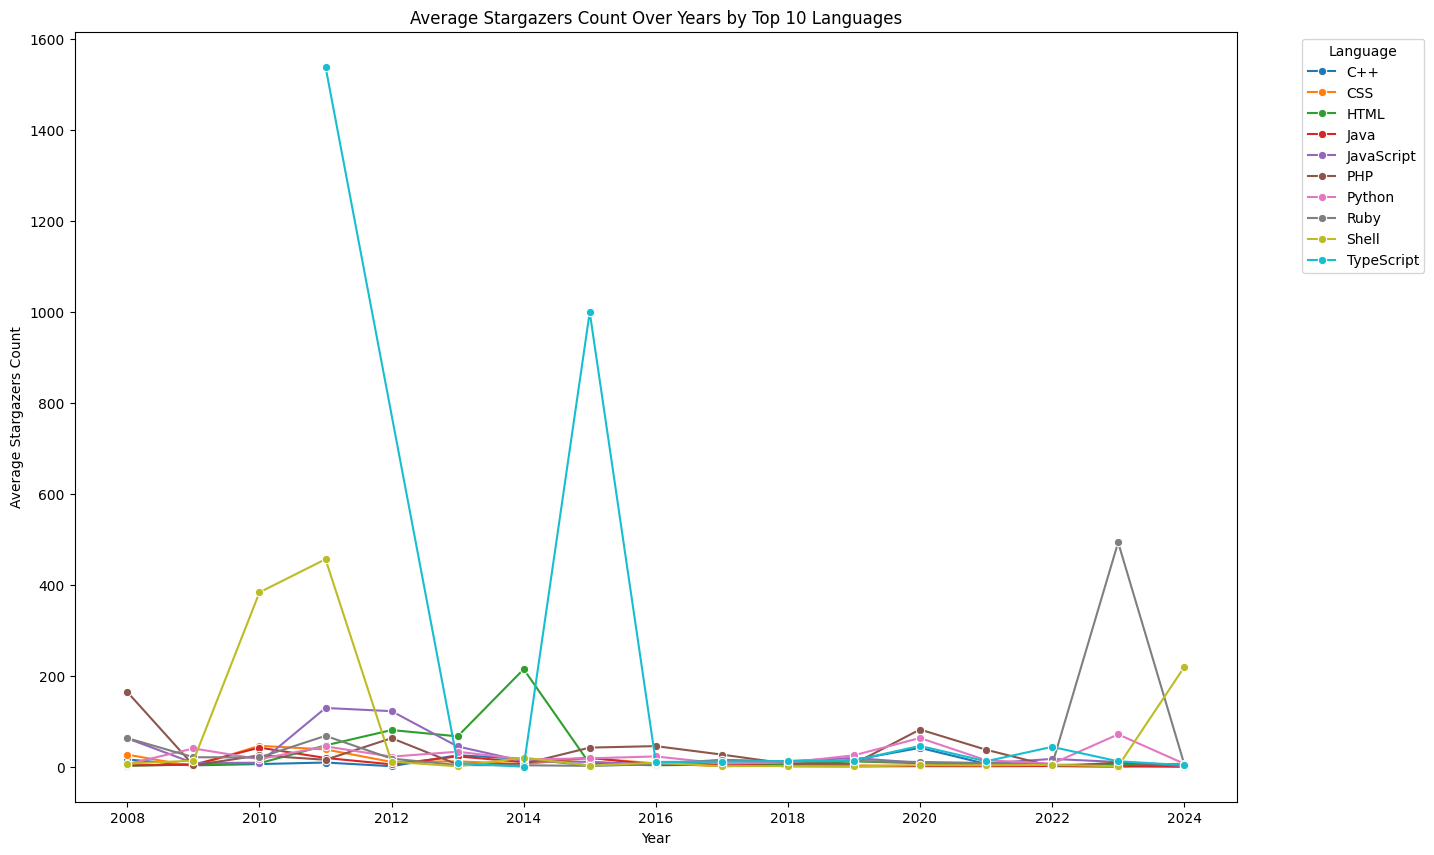

Average Watchers Count Over Years by Top 10 Languages


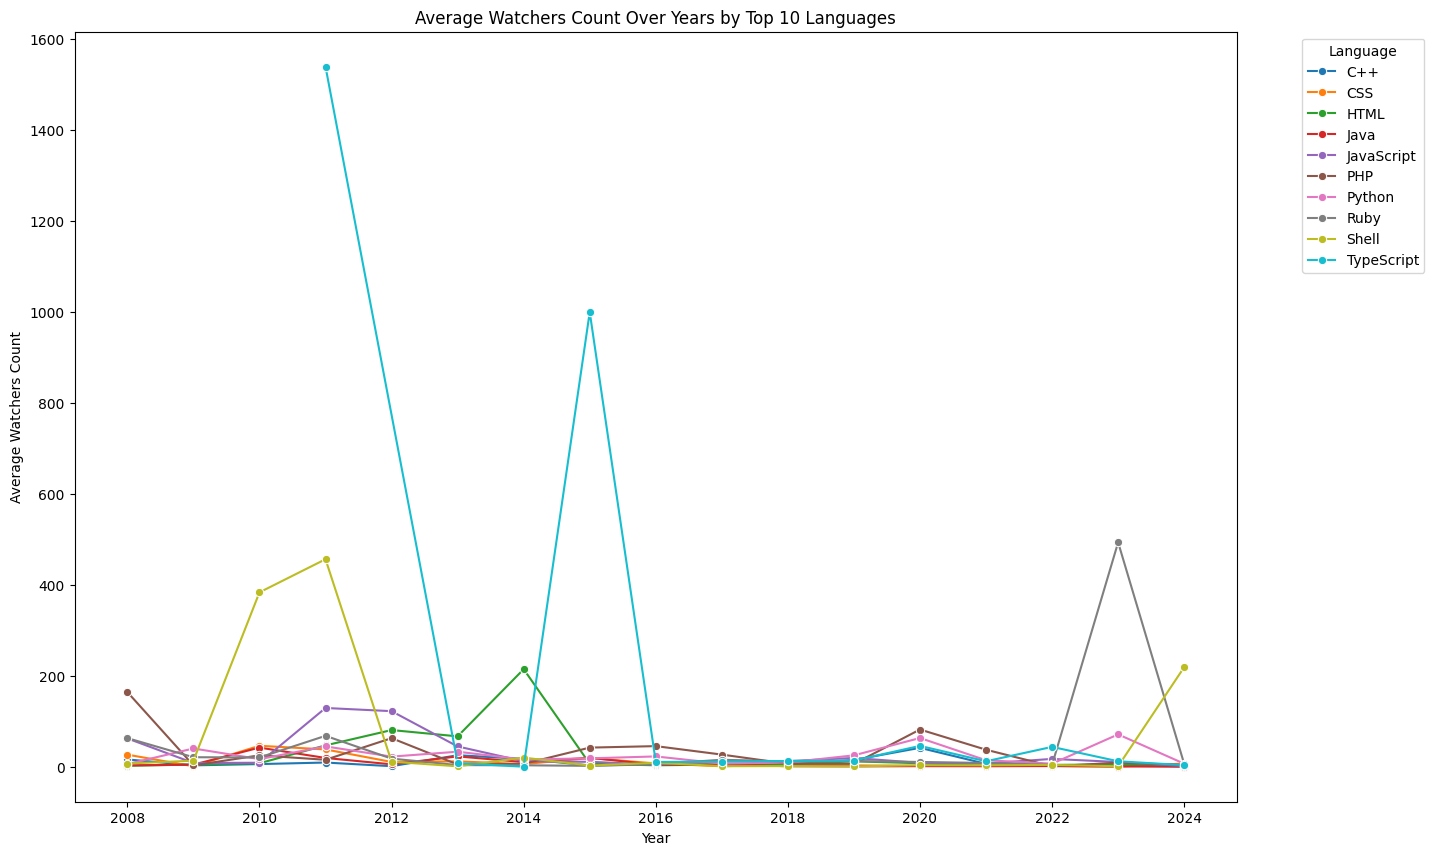

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv(file_pathr)

# Convert 'created_at' to datetime format to extract the year
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['created_at'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)
df['year'] = df['created_at'].dt.year

# Drop rows with missing 'language' or 'year' values
df = df.dropna(subset=['language', 'year'])

# Find the top 10 languages by the number of repositories
top_languages = df['language'].value_counts().head(10).index

# Filter the data to include only the top 10 languages
df_top_languages = df[df['language'].isin(top_languages)]

# Group by year and language to get the count of repositories per language per year
language_counts = df_top_languages.groupby(['year', 'language']).size().reset_index(name='repo_count')

# Group by year and language to get mean stargazers and watchers count for top 10 languages
language_trend = df_top_languages.groupby(['year', 'language']).agg({
    'stargazers_count': 'mean',
    'watchers_count': 'mean'
}).reset_index()

print('Number of Repositories Created Over Years by Top 10 Languages')
# Plot 1: Language Popularity Over Years (Number of Repositories per Language per Year)
plt.figure(figsize=(15, 10))
sns.lineplot(data=language_counts, x='year', y='repo_count', hue='language', marker='o')
plt.title('Number of Repositories Created Over Years by Top 10 Languages')
plt.xlabel('Year')
plt.ylabel('Repository Count')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
print('Average Stargazers Count Over Years by Top 10 Languagess')
# Plot 2: Average Stargazers Count Over Years by Top 10 Languages
plt.figure(figsize=(15, 10))
sns.lineplot(data=language_trend, x='year', y='stargazers_count', hue='language', marker='o')
plt.title('Average Stargazers Count Over Years by Top 10 Languages')
plt.xlabel('Year')
plt.ylabel('Average Stargazers Count')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
print('Average Watchers Count Over Years by Top 10 Languages')
# Plot 3: Average Watchers Count Over Years by Top 10 Languages
plt.figure(figsize=(15, 10))
sns.lineplot(data=language_trend, x='year', y='watchers_count', hue='language', marker='o')
plt.title('Average Watchers Count Over Years by Top 10 Languages')
plt.xlabel('Year')
plt.ylabel('Average Watchers Count')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Plot 3: Language Popularity Over Years (Number of Repositories per Language per Year


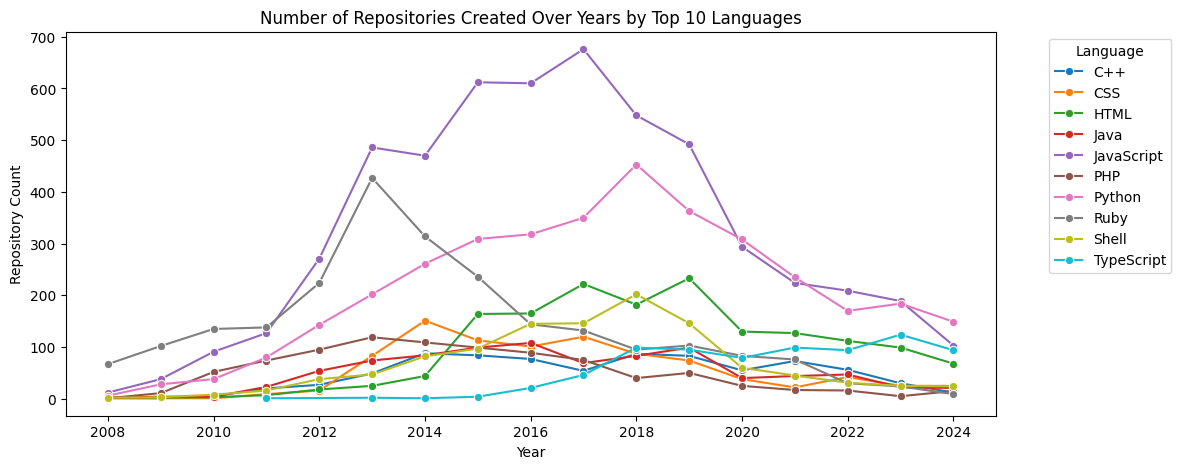

Plot 3: Average Stargazers Count Over Years by Top 10 Languages


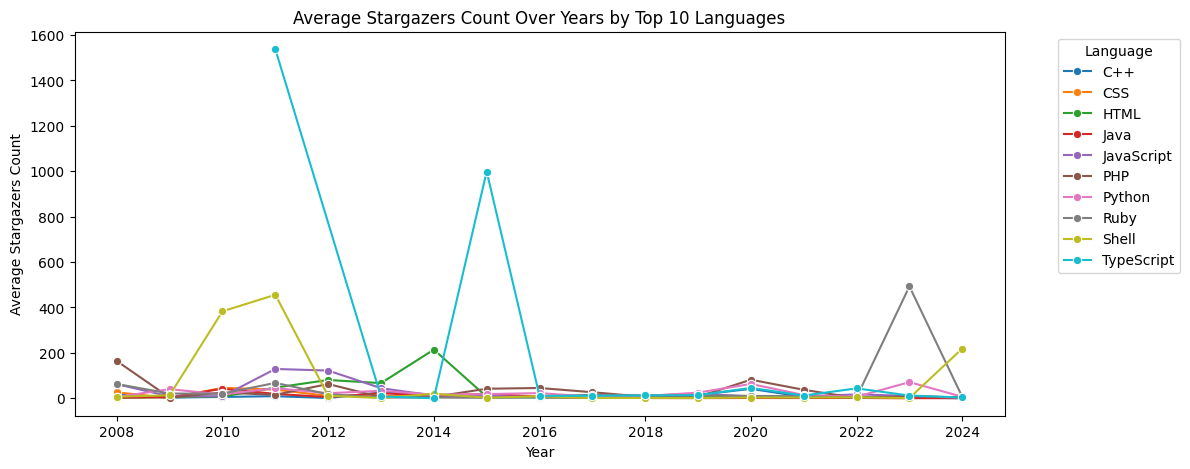

Plot 3: Average Watchers Count Over Years by Top 10 Languages


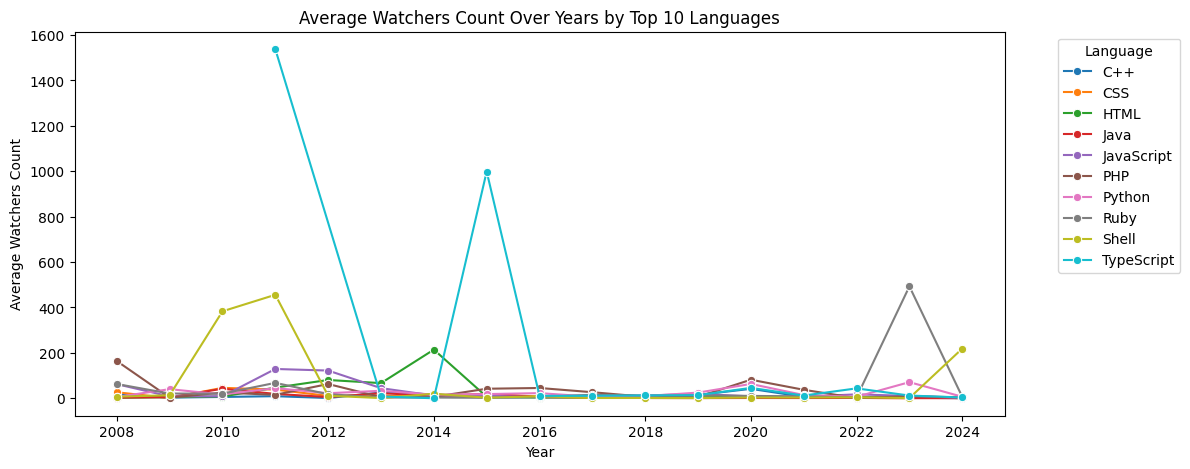

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv(file_pathr)

# Convert 'created_at' to datetime format to extract the year
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['year'] = df['created_at'].dt.year

# Drop rows with missing 'language' or 'year' values
df = df.dropna(subset=['language', 'year'])

# Find the top 10 languages by the number of repositories
top_languages = df['language'].value_counts().head(10).index

# Filter the data to include only the top 10 languages
df_top_languages = df[df['language'].isin(top_languages)]

# Group by year and language to get the count of repositories per language per year
language_counts = df_top_languages.groupby(['year', 'language']).size().reset_index(name='repo_count')

# Group by year and language to get mean stargazers and watchers count for top 10 languages
language_trend = df_top_languages.groupby(['year', 'language']).agg({
    'stargazers_count': 'mean',
    'watchers_count': 'mean'
}).reset_index()

# Function to add data labels on each point in the plot
def add_labels(data, x, y):
    for i in range(data.shape[0]):
        plt.text(data[x].iloc[i], data[y].iloc[i], round(data[y].iloc[i], 2),
                 ha='center', va='bottom', fontsize=8, color='black')
print('Plot 3: Language Popularity Over Years (Number of Repositories per Language per Year')
# Plot 1: Language Popularity Over Years (Number of Repositories per Language per Year)
plt.figure(figsize=(12, 8))
sns.lineplot(data=language_counts, x='year', y='repo_count', hue='language', marker='o')
plt.title('Number of Repositories Created Over Years by Top 10 Languages')
plt.xlabel('Year')
plt.ylabel('Repository Count')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
# Add data labels
# for lang in language_counts['language'].unique():
#     add_labels(language_counts[language_counts['language'] == lang], 'year', 'repo_count')
# Add data table
#table_data = language_counts.pivot(index='year', columns='language', values='repo_count').fillna(0).astype(int)
#plt.table(cellText=table_data.values, colLabels=table_data.columns, rowLabels=table_data.index,
#          cellLoc='center', loc='bottom', bbox=[0, -0.3, 1, 0.2])
plt.subplots_adjust(bottom=0.4)  # Adjust to make room for table
plt.show()
print('Plot 3: Average Stargazers Count Over Years by Top 10 Languages')
# Plot 2: Average Stargazers Count Over Years by Top 10 Languages
plt.figure(figsize=(12, 8))
sns.lineplot(data=language_trend, x='year', y='stargazers_count', hue='language', marker='o')
plt.title('Average Stargazers Count Over Years by Top 10 Languages')
plt.xlabel('Year')
plt.ylabel('Average Stargazers Count')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
# Add data labels
# for lang in language_trend['language'].unique():
#     add_labels(language_trend[language_trend['language'] == lang], 'year', 'stargazers_count')
# Add data table
#table_data = language_trend.pivot(index='year', columns='language', values='stargazers_count').fillna(0).round(2)
#plt.table(cellText=table_data.values, colLabels=table_data.columns, rowLabels=table_data.index,
#          cellLoc='center', loc='bottom', bbox=[0, -0.3, 1, 0.2])
plt.subplots_adjust(bottom=0.4)
plt.show()
print('Plot 3: Average Watchers Count Over Years by Top 10 Languages')
# Plot 3: Average Watchers Count Over Years by Top 10 Languages
plt.figure(figsize=(12, 8))
sns.lineplot(data=language_trend, x='year', y='watchers_count', hue='language', marker='o')
plt.title('Average Watchers Count Over Years by Top 10 Languages')
plt.xlabel('Year')
plt.ylabel('Average Watchers Count')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
# Add data labels
# for lang in language_trend['language'].unique():
#     add_labels(language_trend[language_trend['language'] == lang], 'year', 'watchers_count')
# Add data table
#table_data = language_trend.pivot(index='year', columns='language', values='watchers_count').fillna(0).round(2)
#plt.table(cellText=table_data.values, colLabels=table_data.columns, rowLabels=table_data.index,
#          cellLoc='center', loc='bottom', bbox=[0, -0.3, 1, 0.2])
plt.subplots_adjust(bottom=0.4)
plt.show()


Number of Repositories Created Over Years by Top 10 Languages


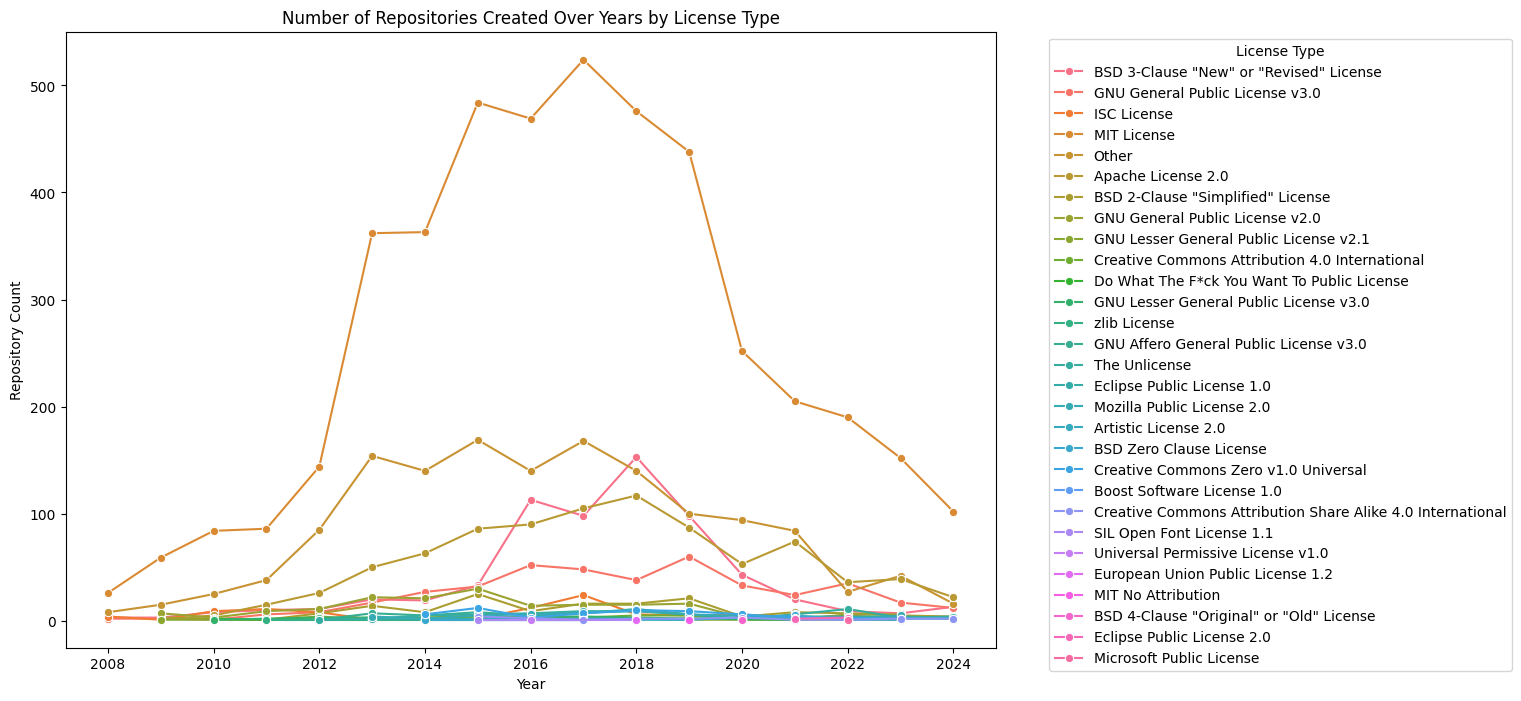

Repositories with Projects and Wikis Enabled by Languages


<Figure size 1200x800 with 0 Axes>

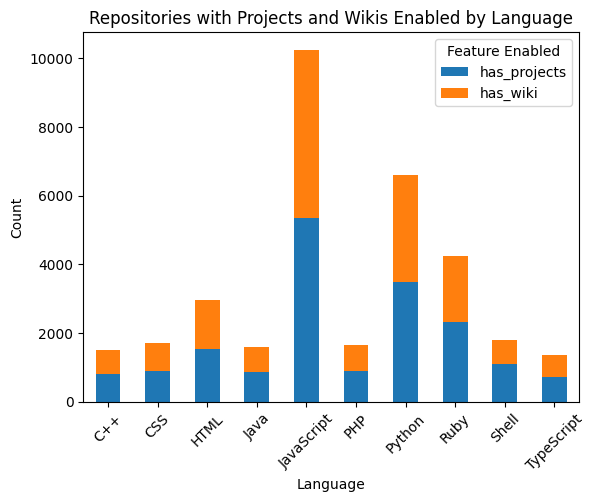

License Types Used for Repositories in Top Languages


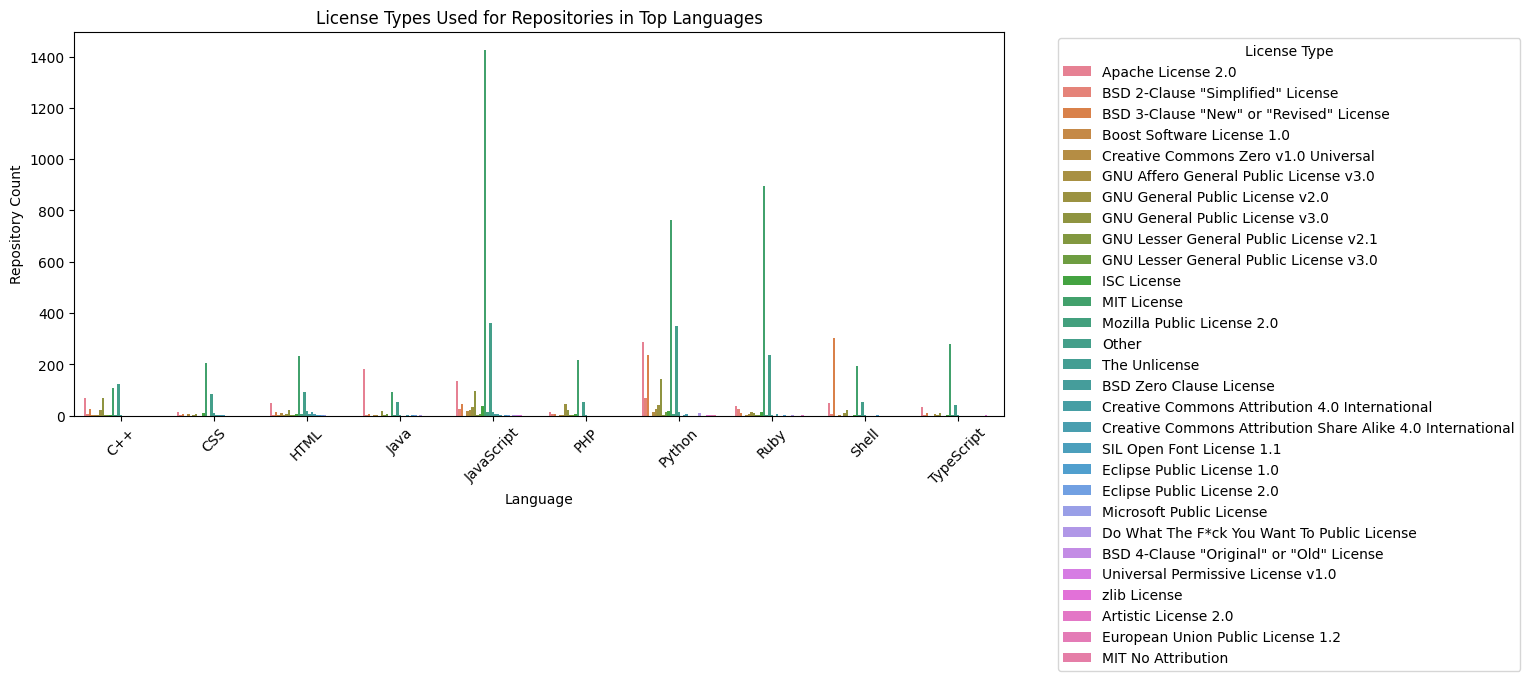

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv(file_pathr)

# Convert 'created_at' to datetime format to extract the year
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['year'] = df['created_at'].dt.year

# Drop rows with missing 'language' or 'year' values
df = df.dropna(subset=['language', 'year'])

# Find the top 10 languages by the number of repositories
top_languages = df['language'].value_counts().head(10).index

# Filter the data to include only the top 10 languages
df_top_languages = df[df['language'].isin(top_languages)]

print('Number of Repositories Created Over Years by Top 10 Languages')
### Analysis 1: Count of Repositories by License Type Over Time
license_counts = df_top_languages.groupby(['year', 'license_name']).size().reset_index(name='repo_count')

plt.figure(figsize=(12, 8))
sns.lineplot(data=license_counts, x='year', y='repo_count', hue='license_name', marker='o')
plt.title('Number of Repositories Created Over Years by License Type')
plt.xlabel('Year')
plt.ylabel('Repository Count')
plt.legend(title='License Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add data table below the plot
# table_data = license_counts.pivot(index='year', columns='license_name', values='repo_count').fillna(0).astype(int)
# plt.table(cellText=table_data.values, colLabels=table_data.columns, rowLabels=table_data.index,
#           cellLoc='center', loc='bottom', bbox=[0, -0.3, 1, 0.2])
# plt.subplots_adjust(bottom=0.4)  # Adjust to make room for table
plt.show()
print('Repositories with Projects and Wikis Enabled by Languages')
### Analysis 2: Repositories with Projects and Wikis Enabled by Language
projects_wiki_counts = df_top_languages.groupby(['language']).agg({
    'has_projects': 'sum',
    'has_wiki': 'sum'
}).reset_index()

plt.figure(figsize=(12, 8))
ax = projects_wiki_counts.set_index('language')[['has_projects', 'has_wiki']].plot(kind='bar', stacked=True)
plt.title('Repositories with Projects and Wikis Enabled by Language')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Feature Enabled')

# Add data table below the plot
# table_data = projects_wiki_counts[['language', 'has_projects', 'has_wiki']]
# plt.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='bottom', bbox=[0, -0.3, 1, 0.2])
# plt.subplots_adjust(bottom=0.4)
plt.show()
print('License Types Used for Repositories in Top Languages')
### Analysis 3: License Types Used for Repositories in Top Languages
language_license_counts = df_top_languages.groupby(['language', 'license_name']).size().reset_index(name='repo_count')

plt.figure(figsize=(12, 8))
sns.barplot(data=language_license_counts, x='language', y='repo_count', hue='license_name')
plt.title('License Types Used for Repositories in Top Languages')
plt.xlabel('Language')
plt.ylabel('Repository Count')
plt.legend(title='License Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Add data table below the plot
# table_data = language_license_counts.pivot(index='language', columns='license_name', values='repo_count').fillna(0).astype(int)
# plt.table(cellText=table_data.values, colLabels=table_data.columns, rowLabels=table_data.index,
#           cellLoc='center', loc='bottom', bbox=[0, -0.3, 1, 0.2])
plt.subplots_adjust(bottom=0.4)
plt.show()
